In [ ]:
#| default_exp core

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2

# Core Methods
> Methods for Fit, Predict, Forecast (fast), Cross Validation and plotting


The core methods of `StatsForecast` are:

* `StatsForecast.fit` 
* `StatsForecast.predict` 
* `StatsForecast.forecast` 
* `StatsForecast.cross_validation` 
* `StatsForecast.plot`

In [ ]:
#| hide
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

from nbdev.showdoc import add_docs, show_doc
from statsforecast.models import Naive

/Users/akmalsoliev/Coding/Git/statsforecast/.venv/lib/python3.10/site-packages/statsforecast/core.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [ ]:
#| export
import inspect
import logging
import random
import re
from itertools import product
from os import cpu_count
from typing import Any, List, Optional, Union, Dict

import matplotlib.pyplot as plt
import matplotlib.colors as cm              
import numpy as np
import pandas as pd
import polars as pl
import plotly.graph_objects as go    
from plotly.subplots import make_subplots
from tqdm.autonotebook import tqdm

from triad import conditional_dispatcher
import fugue.api as fa
from fugue.execution.factory import try_get_context_execution_engine

In [ ]:
#| exporti
if __name__ == '__main__':
    logging.basicConfig(
        format='%(asctime)s %(name)s %(levelname)s: %(message)s',
        datefmt='%Y-%m-%d %H:%M:%S',
    )
logger = logging.getLogger(__name__)

In [ ]:
#| hide
logger.setLevel(logging.ERROR)

In [ ]:
#| hide
from fastcore.test import test_eq, test_fail
from statsforecast.utils import generate_series

In [ ]:
#| exporti
class GroupedArray:
    
    def __init__(self, data, indptr):
        self.data = data
        self.indptr = indptr
        self.n_groups = self.indptr.size - 1
        
    def __getitem__(self, idx):
        if isinstance(idx, int):
            return self.data[self.indptr[idx] : self.indptr[idx + 1]]
        elif isinstance(idx, slice):
            idx = slice(idx.start, idx.stop + 1, idx.step)
            new_indptr = self.indptr[idx].copy()
            new_data = self.data[new_indptr[0] : new_indptr[-1]].copy()            
            new_indptr -= new_indptr[0]
            return GroupedArray(new_data, new_indptr)
        raise ValueError(f'idx must be either int or slice, got {type(idx)}')
    
    def __len__(self):
        return self.n_groups
    
    def __repr__(self):
        return f'GroupedArray(n_data={self.data.size:,}, n_groups={self.n_groups:,})'
    
    def __eq__(self, other):
        if not hasattr(other, 'data') or not hasattr(other, 'indptr'):
            return False
        return np.allclose(self.data, other.data) and np.array_equal(self.indptr, other.indptr)
    
    def fit(self, models):
        fm = np.full((self.n_groups, len(models)), np.nan, dtype=object)
        for i, grp in enumerate(self):
            y = grp[:, 0] if grp.ndim == 2 else grp
            X = grp[:, 1:] if (grp.ndim == 2 and grp.shape[1] > 1) else None
            for i_model, model in enumerate(models):
                new_model = model.new()
                fm[i, i_model] = new_model.fit(y=y, X=X)
        return fm
    
    def _get_cols(self, models, attr, h, X, level=tuple()):
        n_models = len(models)
        cuts = np.full(n_models + 1, fill_value=np.nan, dtype=np.int32)
        has_level_models = np.full(n_models, fill_value=False, dtype=bool) 
        cuts[0] = 0
        for i_model, model in enumerate(models):
            len_cols = 1 # mean
            has_level = 'level' in inspect.signature(getattr(model, attr)).parameters and len(level) > 0
            has_level_models[i_model] = has_level
            if has_level:
                len_cols += 2 * len(level) #levels
            cuts[i_model + 1] = len_cols + cuts[i_model]
        return cuts, has_level_models
    
    def _output_fcst(self, models, attr, h, X, level=tuple()):
        #returns empty output according to method
        cuts, has_level_models = self._get_cols(models=models, attr=attr, h=h, X=X, level=level)
        out = np.full((self.n_groups * h, cuts[-1]), fill_value=np.nan, dtype=np.float32)
        return out, cuts, has_level_models
        
    def predict(self, fm, h, X=None, level=tuple()):
        #fm stands for fitted_models
        #and fm should have fitted_model
        fcsts, cuts, has_level_models = self._output_fcst(
            models=fm[0], attr='predict', 
            h=h, X=X, level=level
        )
        matches = ['mean', 'lo', 'hi']
        cols = []
        for i_model in range(fm.shape[1]):
            has_level = has_level_models[i_model]
            kwargs = {}
            if has_level:
                kwargs['level'] = level
            for i, _ in enumerate(self):
                if X is not None:
                    X_ = X[i]
                else:
                    X_ = None
                res_i = fm[i, i_model].predict(h=h, X=X_, **kwargs)
                cols_m = [key for key in res_i.keys() if any(key.startswith(m) for m in matches)]
                fcsts_i = np.vstack([res_i[key] for key in cols_m]).T
                model_name = repr(fm[i, i_model])
                cols_m = [f'{model_name}' if col == 'mean' else f'{model_name}-{col}' for col in cols_m]
                if fcsts_i.ndim == 1:
                    fcsts_i = fcsts_i[:, None]
                fcsts[i * h : (i + 1) * h, cuts[i_model]:cuts[i_model + 1]] = fcsts_i
            cols += cols_m
        return fcsts, cols
    
    def fit_predict(self, models, h, X=None, level=tuple()):
        #fitted models
        fm = self.fit(models=models)
        #forecasts
        fcsts, cols = self.predict(fm=fm, h=h, X=X, level=level)
        return fm, fcsts, cols
    
    def forecast(self, models, h, fallback_model=None, fitted=False, X=None, level=tuple(), verbose=False):
        fcsts, cuts, has_level_models = self._output_fcst(
            models=models, attr='forecast', 
            h=h, X=X, level=level
        )
        matches = ['mean', 'lo', 'hi']
        matches_fitted = ['fitted', 'fitted-lo', 'fitted-hi']
        if fitted:
            #for the moment we dont return levels for fitted values in 
            #forecast mode
            fitted_vals = np.full((self.data.shape[0], 1 + cuts[-1]), np.nan, dtype=np.float32)
            if self.data.ndim == 1:
                fitted_vals[:, 0] = self.data
            else:
                fitted_vals[:, 0] = self.data[:, 0]
        iterable = tqdm(enumerate(self), 
                        disable=(not verbose), 
                        total=len(self),
                        desc='Forecast')
        for i, grp in iterable:
            y_train = grp[:, 0] if grp.ndim == 2 else grp
            X_train = grp[:, 1:] if (grp.ndim == 2 and grp.shape[1] > 1) else None
            if X is not None:
                X_f = X[i]
            else:
                X_f = None
            cols = []
            cols_fitted = []
            for i_model, model in enumerate(models):
                has_level = has_level_models[i_model]
                kwargs = {}
                if has_level:
                    kwargs['level'] = level
                try:
                    res_i = model.forecast(h=h, y=y_train, X=X_train, X_future=X_f, fitted=fitted, **kwargs)
                except Exception as error:
                    if fallback_model is not None:
                        res_i = fallback_model.forecast(h=h, y=y_train, X=X_train, X_future=X_f, fitted=fitted, **kwargs)
                    else:
                        raise error
                cols_m = [key for key in res_i.keys() if any(key.startswith(m) for m in matches)]
                fcsts_i = np.vstack([res_i[key] for key in cols_m]).T
                cols_m = [f'{repr(model)}' if col == 'mean' else f'{repr(model)}-{col}' for col in cols_m]
                if fcsts_i.ndim == 1:
                    fcsts_i = fcsts_i[:, None]
                fcsts[i * h : (i + 1) * h, cuts[i_model]:cuts[i_model + 1]] = fcsts_i
                cols += cols_m
                if fitted:
                    cols_m_fitted = [key for key in res_i.keys() if any(key.startswith(m) for m in matches_fitted)]
                    fitted_i = np.vstack([res_i[key] for key in cols_m_fitted]).T
                    cols_m_fitted = [f'{repr(model)}' \
                                     if col == 'fitted' else f"{repr(model)}-{col.replace('fitted-', '')}" \
                                     for col in cols_m_fitted]
                    fitted_vals[self.indptr[i] : self.indptr[i + 1], (cuts[i_model] + 1):(cuts[i_model + 1] + 1)] = fitted_i
                    cols_fitted += cols_m_fitted
        result = {'forecasts': fcsts, 'cols': cols}
        if fitted:
            result['fitted'] = {'values': fitted_vals}
            result['fitted']['cols'] = ['y'] + cols_fitted
        return result
    
    def cross_validation(self, models, h, test_size, fallback_model=None,
                         step_size=1, input_size=None, fitted=False, level=tuple(), 
                         refit=True, verbose=False):
        # output of size: (ts, window, h)
        if (test_size - h) % step_size:
            raise Exception('`test_size - h` should be module `step_size`')
        n_windows = int((test_size - h) / step_size) + 1
        n_models = len(models)
        cuts, has_level_models = self._get_cols(models=models, attr='forecast', h=h, X=None, level=level)
        # first column of out is the actual y
        out = np.full((self.n_groups, n_windows, h, 1 + cuts[-1]), np.nan, dtype=np.float32)
        if fitted:
            fitted_vals = np.full((self.data.shape[0], n_windows, n_models + 1), np.nan, dtype=np.float32)
            fitted_idxs = np.full((self.data.shape[0], n_windows), False, dtype=bool)
            last_fitted_idxs = np.full_like(fitted_idxs, False, dtype=bool)
        matches = ['mean', 'lo', 'hi']
        steps = list(range(-test_size, -h + 1, step_size))
        for i_ts, grp in enumerate(self):
            iterable = tqdm(enumerate(steps, start=0), 
                            desc=f'Cross Validation Time Series {i_ts + 1}', 
                            disable=(not verbose),
                            total=len(steps))
            for i_window, cutoff in iterable:
                end_cutoff = cutoff + h
                in_size_disp = cutoff if input_size is None else input_size 
                y = grp[(cutoff - in_size_disp):cutoff]
                y_train = y[:, 0] if y.ndim == 2 else y
                X_train = y[:, 1:] if (y.ndim == 2 and y.shape[1] > 1) else None
                y_test = grp[cutoff:] if end_cutoff == 0 else grp[cutoff:end_cutoff]
                X_future = y_test[:, 1:] if (y_test.ndim == 2 and y_test.shape[1] > 1) else None
                out[i_ts, i_window, :, 0] = y_test[:, 0] if y.ndim == 2 else y_test
                if fitted:
                    fitted_vals[self.indptr[i_ts] : self.indptr[i_ts + 1], i_window, 0][
                        (cutoff - in_size_disp):cutoff
                    ] = y_train
                    fitted_idxs[self.indptr[i_ts] : self.indptr[i_ts + 1], i_window][
                        (cutoff - in_size_disp):cutoff
                    ] = True
                    last_fitted_idxs[
                        self.indptr[i_ts] : self.indptr[i_ts + 1], i_window
                    ][cutoff-1] = True
                cols = ['y']
                for i_model, model in enumerate(models):
                    has_level = has_level_models[i_model]
                    kwargs = {}
                    if has_level:
                        kwargs['level'] = level
                    if refit:
                        try:
                            res_i = model.forecast(h=h, y=y_train, X=X_train, 
                                                   X_future=X_future, fitted=fitted, **kwargs)
                        except Exception as error:
                            if fallback_model is not None:
                                res_i = fallback_model.forecast(h=h, y=y_train, X=X_train, 
                                                                X_future=X_future, fitted=fitted, **kwargs)
                            else:
                                raise error
                    else:
                        if i_window == 0:
                            # for the first window we have to fit each model
                            model = model.fit(y=y_train, X=X_train)
                            if fallback_model is not None:
                                fallback_model = fallback_model.fit(y=y_train, X=X_train)
                        try:
                            res_i = model.forward(h=h, y=y_train, X=X_train, 
                                                                   X_future=X_future, fitted=fitted, **kwargs)
                        except Exception as error:
                            if fallback_model is not None:
                                res_i = fallback_model.forward(h=h, y=y_train, X=X_train, 
                                                               X_future=X_future, fitted=fitted, **kwargs)
                            else:
                                raise error
                    cols_m = [key for key in res_i.keys() if any(key.startswith(m) for m in matches)]
                    fcsts_i = np.vstack([res_i[key] for key in cols_m]).T
                    cols_m = [f'{repr(model)}' if col == 'mean' else f'{repr(model)}-{col}' for col in cols_m]
                    out[i_ts, i_window, :, (1 + cuts[i_model]):(1 + cuts[i_model + 1])] = fcsts_i
                    if fitted:
                        fitted_vals[self.indptr[i_ts] : self.indptr[i_ts + 1], i_window, i_model + 1][
                            (cutoff - in_size_disp):cutoff
                        ] = res_i['fitted']
                    cols += cols_m
        result = {'forecasts': out.reshape(-1, 1 + cuts[-1]), 'cols': cols}
        if fitted:
            result['fitted'] = {
                'values': fitted_vals, 
                'idxs': fitted_idxs, 
                'last_idxs': last_fitted_idxs,
                'cols': ['y'] + [repr(model) for model in models]
            }
        return result

    def split(self, n_chunks):
        return [self[x[0] : x[-1] + 1] for x in np.array_split(range(self.n_groups), n_chunks) if x.size]
    
    def split_fm(self, fm, n_chunks):
        return [fm[x[0] : x[-1] + 1] for x in np.array_split(range(self.n_groups), n_chunks) if x.size]

In [ ]:
#| hide
# sum ahead just returns the last value
# added with h future values 
class SumAhead:
    
    def __init__(self):
        pass
    
    def fit(self, y, X):
        self.last_value = y[-1]
        self.fitted_values = np.full(y.size, np.nan, np.float32)
        self.fitted_values[1:] = y[:1]
        return self
    
    def predict(self, h, X=None, level=None):
        mean = self.last_value + np.arange(1, h + 1)
        res = {'mean': mean}
        if level is not None:
            for lv in level:
                res[f'lo-{lv}'] = mean - 1.0
                res[f'hi-{lv}'] = mean + 1.0
        return res
    
    def __repr__(self):
        return 'SumAhead'
    
    def forecast(self, y, h, X=None, X_future=None, fitted=False, level=None):
        mean = y[-1] + np.arange(1, h + 1)
        res = {'mean': mean}
        if fitted:
            fitted_values = np.full(y.size, np.nan, np.float32)
            fitted_values[1:] = y[1:]
            res['fitted'] = fitted_values
        if level is not None:
            for lv in level:
                res[f'lo-{lv}'] = mean - 1.0
                res[f'hi-{lv}'] = mean + 1.0
        return res
    
    def forward(self, y, h, X=None, X_future=None, fitted=False, level=None):
        # fix self.last_value for test purposes
        mean = self.last_value + np.arange(1, h + 1)
        res = {'mean': mean}
        if fitted:
            fitted_values = np.full(y.size, np.nan, np.float32)
            fitted_values[1:] = y[1:]
            res['fitted'] = fitted_values
        if level is not None:
            for lv in level:
                res[f'lo-{lv}'] = mean - 1.0
                res[f'hi-{lv}'] = mean + 1.0
        return res
    
    def new(self):
        b = type(self).__new__(type(self))
        b.__dict__.update(self.__dict__)
        return b

In [ ]:
#| hide
#data used for tests
data = np.arange(12)
indptr = np.array([0, 4, 8, 12])

# test we can recover the 
# number of series
ga = GroupedArray(data, indptr)
test_eq(len(ga), 3)

#test splits of data
splits = ga.split(2)
test_eq(splits[0], GroupedArray(data[:8], indptr[:3]))
test_eq(splits[1], GroupedArray(data[8:], np.array([0, 4])))

# fitting models for each ts
models = [Naive(), Naive()]
fm = ga.fit(models)
test_eq(fm.shape, (3, 2))
test_eq(len(ga.split_fm(fm, 2)), 2)

# test forecasts
exp_fcsts = np.hstack([2 * [data[i]] for i in indptr[1:] - 1])
fcsts, cols = ga.predict(fm=fm, h=2)
np.testing.assert_equal(
    fcsts,
    np.hstack([exp_fcsts[:, None], exp_fcsts[:, None]]),
)

#test fit and predict pipelie
fm_fp, fcsts_fp, cols_fp = ga.fit_predict(models=models, h=2) 
test_eq(fm_fp.shape, (3, 2))
np.testing.assert_equal(fcsts_fp, fcsts)
np.testing.assert_equal(cols_fp, cols)

#test levels
fm_lv, fcsts_lv, cols_lv = ga.fit_predict(models=models, h=2, level=(50, 90))
test_eq(fcsts_lv.shape, (2 * len(ga), 10)) 

#test forecast
fcst_f = ga.forecast(models=models, h=2, fitted=True)
test_eq(fcst_f['forecasts'], fcsts_fp)
test_eq(fcst_f['cols'], cols_fp)

In [ ]:
#| hide
class NullModel:
    
    def __init__(self):
        pass
    
    def forecast(self):
        pass
    
    def __repr__(self):
        return 'NullModel'
#test fallback model
fcst_f = ga.forecast(models=[NullModel(), NullModel()], fallback_model=Naive(), h=2, fitted=True)
test_eq(fcst_f['forecasts'], fcsts_fp)
test_eq(fcst_f['cols'], ['NullModel', 'NullModel'])
test_fail(ga.forecast, kwargs={'models': [NullModel()]})

In [ ]:
#| hide
#test levels
lv = (50, 60)
h = 2
#test for forecasts
fcsts_lv = ga.forecast(models=[SumAhead()], h=h, fitted=True, level=lv)
test_eq(
    fcsts_lv['forecasts'].shape,
    (len(ga) * h, 1 + 2 * len(lv))
)
test_eq(
    fcsts_lv['cols'],
    ['SumAhead', 
     'SumAhead-lo-50', 
     'SumAhead-hi-50',
     'SumAhead-lo-60',
     'SumAhead-hi-60']
)
#fit and predict pipeline
fm_lv_fp, fcsts_lv_fp, cols_lv_fp = ga.fit_predict(models=[SumAhead()], h=h, level=lv)
test_eq(
    fcsts_lv['forecasts'],
    fcsts_lv_fp
)
test_eq(
    fcsts_lv['cols'],
    cols_lv_fp
)

In [ ]:
#| hide
# tests for cross valiation
data = np.hstack([np.arange(10), np.arange(100, 200), np.arange(20, 40)])
indptr = np.array([0, 10, 110, 130])
ga = GroupedArray(data, indptr)
    
res_cv = ga.cross_validation(models=[SumAhead()], h=2, test_size=5, fitted=True)
fcsts_cv = res_cv['forecasts']
cols_cv = res_cv['cols']
test_eq(
    fcsts_cv[:, cols_cv.index('y')], 
    fcsts_cv[:, cols_cv.index('SumAhead')]
)

#levels
res_cv_lv = ga.cross_validation(models=[SumAhead(), Naive()], h=2, test_size=5, level=(50, 60))

In [ ]:
#| hide
actual_step_size = np.unique(np.diff(fcsts_cv[:, cols_cv.index('SumAhead')].reshape((3, -1, 2)), axis=1))
test_eq(actual_step_size, 1)

In [ ]:
#| hide
horizons = [1, 2, 3, 2]
test_sizes = [3, 4, 6, 6]
step_sizes = [2, 2, 3, 4]
for h, test_size, step_size in zip(horizons, test_sizes, step_sizes):
    res_cv = ga.cross_validation(
        models=[SumAhead()], h=h, 
        test_size=test_size, 
        step_size=step_size,
        fitted=True
    )
    fcsts_cv = res_cv['forecasts']
    cols_cv = res_cv['cols']
    test_eq(
        fcsts_cv[:, cols_cv.index('y')], 
        fcsts_cv[:, cols_cv.index('SumAhead')]
    )
    fcsts_cv = fcsts_cv[:, cols_cv.index('SumAhead')].reshape((3, -1, h))
    actual_step_size = np.unique(
        np.diff(fcsts_cv, axis=1)
    )
    test_eq(actual_step_size, step_size)
    actual_n_windows = res_cv['forecasts'].shape[1]
    test_eq(actual_n_windows, int((test_size - h)/step_size) + 1)

In [ ]:
#| hide 
def fail_cv(h, test_size, step_size):
    return ga.cross_validation(models=[SumAhead()], h=h, test_size=test_size, step_size=step_size)
test_fail(fail_cv, contains='module', kwargs=dict(h=2, test_size=5, step_size=2))

In [ ]:
#| hide
#test fallback model
# cross validation
fcst_cv_f = ga.cross_validation(
    models=[NullModel(), NullModel()], 
    fallback_model=Naive(), h=2, 
    test_size=5,
    fitted=True
)
fcst_cv_naive = ga.cross_validation(
    models=[Naive(), Naive()], 
    h=2, 
    test_size=5,
    fitted=True
)
test_eq(fcst_cv_f['forecasts'], fcst_cv_naive['forecasts'])
np.testing.assert_array_equal(fcst_cv_f['fitted']['values'], fcst_cv_naive['fitted']['values'])

In [ ]:
#| hide
# test cross validation without refit
res_cv_wo_refit = ga.cross_validation(models=[SumAhead()], h=2, test_size=5, refit=False, level=(50, 60))
res_cv_refit = ga.cross_validation(models=[SumAhead()], h=2, test_size=5, refit=True, level=(50, 60))
test_fail(test_eq, args=(res_cv_wo_refit['forecasts'], res_cv_refit['forecasts']))
#test first forecasts are equal
test_eq(
    res_cv_wo_refit['forecasts'][[0, 8, 16]],
    res_cv_refit['forecasts'][[0, 8, 16]]
)

In [ ]:
#| hide
from statsforecast.models import AutoCES

In [ ]:
#| hide
res_cv_wo_refit = ga.cross_validation(models=[AutoCES()], h=2, test_size=5, refit=False, level=(50, 60))
res_cv_refit = ga.cross_validation(models=[AutoCES()], h=2, test_size=5, refit=True, level=(50, 60))
test_fail(test_eq, args=(res_cv_wo_refit['forecasts'], res_cv_refit['forecasts']))
#test first forecasts are equal
test_eq(
    res_cv_wo_refit['forecasts'][[0, 8, 16]],
    res_cv_refit['forecasts'][[0, 8, 16]]
)

In [ ]:
#| exporti
def _grouped_array_from_df(df, sort_df):
    df = df.set_index('ds', append=True)
    if not df.index.is_monotonic_increasing and sort_df:
        df = df.sort_index()
    data = df.values.astype(np.float32)
    indices_sizes = df.index.get_level_values('unique_id').value_counts(sort=False)
    indices = indices_sizes.index
    sizes = indices_sizes.values
    cum_sizes = sizes.cumsum()
    dates = df.index.get_level_values('ds')[cum_sizes - 1]
    indptr = np.append(0, cum_sizes).astype(np.int32)
    return GroupedArray(data, indptr), indices, dates, df.index

In [ ]:
#| hide
series = generate_series(10_000, n_static_features=2, equal_ends=False)
sorted_series = series.sort_values(['unique_id', 'ds'])
unsorted_series = sorted_series.sample(frac=1.0)
ga, indices, dates, ds = _grouped_array_from_df(unsorted_series, sort_df=True)

np.testing.assert_allclose(ga.data, sorted_series.drop(columns='ds').values)
test_eq(indices, sorted_series.index.unique(level='unique_id'))
test_eq(dates, series.groupby('unique_id')['ds'].max().values)

In [ ]:
#| exporti
def _cv_dates(last_dates, freq, h, test_size, step_size=1):
    #assuming step_size = 1
    if (test_size - h) % step_size:
        raise Exception('`test_size - h` should be module `step_size`')
    n_windows = int((test_size - h) / step_size) + 1
    if len(np.unique(last_dates)) == 1:
        if issubclass(last_dates.dtype.type, np.integer):
            total_dates = np.arange(last_dates[0] - test_size + 1, last_dates[0] + 1)
            out = np.empty((h * n_windows, 2), dtype=last_dates.dtype)
            freq = 1
        else:
            total_dates = pd.date_range(end=last_dates[0], periods=test_size, freq=freq)
            out = np.empty((h * n_windows, 2), dtype='datetime64[s]')
        for i_window, cutoff in enumerate(range(-test_size, -h + 1, step_size), start=0):
            end_cutoff = cutoff + h
            out[h * i_window : h * (i_window + 1), 0] = total_dates[cutoff:] if end_cutoff == 0 else total_dates[cutoff:end_cutoff]
            out[h * i_window : h * (i_window + 1), 1] = np.tile(total_dates[cutoff] - freq, h)
        dates = pd.DataFrame(np.tile(out, (len(last_dates), 1)), columns=['ds', 'cutoff'])
    else:
        dates = pd.concat([_cv_dates(np.array([ld]), freq, h, test_size, step_size) for ld in last_dates])
        dates = dates.reset_index(drop=True)
    return dates

In [ ]:
#| hide
ds_int_cv_test = pd.DataFrame({
    'ds': np.hstack([
        [46, 47, 48],
        [47, 48, 49],
        [48, 49, 50]
    ]),
    'cutoff': [45] * 3 + [46] * 3 + [47] * 3
}, dtype=np.int64)
test_eq(ds_int_cv_test, _cv_dates(np.array([50], dtype=np.int64), 'D', 3, 5))

In [ ]:
#| hide
ds_int_cv_test = pd.DataFrame({
    'ds': np.hstack([
        [46, 47, 48],
        [48, 49, 50]
    ]),
    'cutoff': [45] * 3 + [47] * 3
}, dtype=np.int64)
test_eq(ds_int_cv_test, _cv_dates(np.array([50], dtype=np.int64), 'D', 3, 5, step_size=2))

In [ ]:
#| hide
for e_e in [True, False]:
    n_series = 2
    ga, indices, dates, ds = _grouped_array_from_df(generate_series(n_series, equal_ends=e_e), sort_df=True)
    freq = pd.tseries.frequencies.to_offset('D')
    horizon = 3
    test_size = 5
    df_dates = _cv_dates(last_dates=dates, freq=freq, h=horizon, test_size=test_size)
    test_eq(len(df_dates), n_series * horizon * (test_size - horizon + 1)) 

In [ ]:
#| exporti
def _get_n_jobs(n_groups, n_jobs):
    if n_jobs == -1 or (n_jobs is None):
        actual_n_jobs = cpu_count()
    else:
        actual_n_jobs = n_jobs
    return min(n_groups, actual_n_jobs)

In [ ]:
#| hide
#tests for more series than resources
test_eq(_get_n_jobs(100, -1), cpu_count()) 
test_eq(_get_n_jobs(100, None), cpu_count())
test_eq(_get_n_jobs(100, 2), 2)

In [ ]:
#| hide
#tests for less series than resources
test_eq(_get_n_jobs(1, -1), 1) 
test_eq(_get_n_jobs(1, None), 1)
test_eq(_get_n_jobs(2, 10), 2)

In [ ]:
#| exporti
def _parse_ds_type(df):
    if not pd.api.types.is_datetime64_any_dtype(df['ds']) and not issubclass(df['ds'].dtype.type, np.integer):
        df = df.copy()
        try:
            df['ds'] = pd.to_datetime(df['ds'])
        except Exception as e:
            msg = (
                'Failed to parse `ds` column as datetime. '
                'Please use `pd.to_datetime` outside to fix the error. '
                f'{e}'
            )
            raise Exception(msg) from e
    return df

In [ ]:
#| exporti
class _StatsForecast:
    
    def __init__(
            self, 
            models: List[Any],
            freq: str,
            n_jobs: int = 1,
            df: Optional[pd.DataFrame] = None,
            sort_df: bool = True,
            fallback_model: Optional[Any] = None,
            verbose: bool = False,
        ):
        """Train statistical models.

        The `StatsForecast` class allows you to efficiently fit multiple `StatsForecast` models 
        for large sets of time series. It operates with pandas DataFrame `df` that identifies series 
        and datestamps with the `unique_id` and `ds` columns. The `y` column denotes the target 
        time series variable. 

        The class has memory-efficient `StatsForecast.forecast` method that avoids storing partial 
        model outputs. While the `StatsForecast.fit` and `StatsForecast.predict` methods with 
        Scikit-learn interface store the fitted models.

        The `StatsForecast` class offers parallelization utilities with Dask, Spark and Ray back-ends.
        See distributed computing example [here](https://github.com/Nixtla/statsforecast/tree/main/experiments/ray).

        Parameters
        ----------
        models : List[Any]
            List of instantiated objects models.StatsForecast.
        freq : str
            Frequency of the data.
            See [panda's available frequencies](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases).
        n_jobs : int (default=1)
            Number of jobs used in the parallel processing, use -1 for all cores.
        df : pandas.DataFrame, optional (default=None)
            DataFrame with columns [`unique_id`, `ds`, `y`] and exogenous.
        sort_df : bool (default=True)
            If True, sort `df` by [`unique_id`,`ds`].
        fallback_model : Any, optional (default=None)
            Model to be used if a model fails. 
            Only works with the `forecast` and `cross_validation` methods.
        verbose : bool (default=True)
            Prints TQDM progress bar when `n_jobs=1`.
        backend : Any, optional (default=None)
            Backend used to distributed processing. 
            Only methods `forecast` add `cross_validation` are currently supported.
        """
    
        # TODO @fede: needed for residuals, think about it later
        self.models = models
        self.freq = pd.tseries.frequencies.to_offset(freq)
        self.n_jobs = n_jobs
        self.fallback_model = fallback_model        
        self.verbose = verbose and self.n_jobs == 1
        self._prepare_fit(df=df, sort_df=sort_df)

    def _validate_df(self, df):
        if isinstance(df, pd.DataFrame):
            return df, 'pandas'
        elif isinstance(df, pl.DataFrame):
            df = (
                df
                .to_pandas()
                .set_index('unique_id')
            )
            return df, 'polars'
        else:
            raise ValueError(f"{type(df)} is not allowed")
        
    def _prepare_fit(self, df, sort_df):
        if df is not None:
            df, self.engine = self._validate_df(df)
            if df.index.name != 'unique_id':
                df = df.set_index('unique_id')
            df = _parse_ds_type(df)
            self.ga, self.uids, self.last_dates, self.ds = _grouped_array_from_df(df, sort_df)
            self.n_jobs = _get_n_jobs(len(self.ga), self.n_jobs)
            self.sort_df = sort_df
        
    def fit(
            self,
            df: Optional[pd.DataFrame] = None, 
            sort_df: bool = True 
        ):
        """Fit statistical models.

        Fit `models` to a large set of time series from DataFrame `df`
        and store fitted models for later inspection.

        Parameters
        ----------
        df : pandas.DataFrame, optional (default=None)
            DataFrame with columns [`unique_id`, `ds`, `y`] and exogenous.
            If None, the `StatsForecast` class should have been instantiated
            using `df`.
        sort_df : bool (default=True)
            If True, sort `df` by [`unique_id`,`ds`].

        Returns
        -------
        self : StatsForecast
            Returns with stored `StatsForecast` fitted `models`.
        """
        self._prepare_fit(df, sort_df)
        if self.n_jobs == 1:
            self.fitted_ = self.ga.fit(models=self.models)
        else:
            self.fitted_ = self._fit_parallel()
        return self
    
    def _make_future_df(self, h: int):
        if issubclass(self.last_dates.dtype.type, np.integer):
            last_date_f = lambda x: np.arange(x + 1, x + 1 + h, dtype=self.last_dates.dtype)
        else:
            last_date_f = lambda x: pd.date_range(x + self.freq, periods=h, freq=self.freq)
        if len(np.unique(self.last_dates)) == 1:
            dates = np.tile(last_date_f(self.last_dates[0]), len(self.ga))
        else:
            dates = np.hstack([
                last_date_f(last_date)
                for last_date in self.last_dates            
            ])
        idx = pd.Index(np.repeat(self.uids, h), name='unique_id')
        df = pd.DataFrame({'ds': dates}, index=idx)
        return df
    
    def _parse_X_level(self, h, X, level):
        if X is not None:
            if X.index.name != 'unique_id':
                X = X.set_index('unique_id')
            expected_shape = (h * len(self.ga), self.ga.data.shape[1])
            if X.shape != expected_shape:
                raise ValueError(f'Expected X to have shape {expected_shape}, but got {X.shape}')
            X, _, _, _ = _grouped_array_from_df(X, sort_df=self.sort_df)
        if level is None:
            level = tuple()
        return X, level
    
    def _to_polars(self, df) -> pl.DataFrame:
        full_df = df.reset_index()
        for col in full_df.columns:
            if full_df[col].dtype == 'category':
                full_df[col] = full_df[col].map(str)        
        return pl.from_pandas(full_df)
    
    def predict(
            self,
            h: int,
            X_df: Optional[pd.DataFrame] = None,
            level: Optional[List[int]] = None,
        ):
        """Predict statistical models.

        Use stored fitted `models` to predict large set of time series from DataFrame `df`.        

        Parameters
        ----------
        h : int
            Forecast horizon.
        X_df : pandas.DataFrame, optional (default=None)
            DataFrame with [`unique_id`, `ds`] columns and `df`'s future exogenous.
        level : List[float], optional (default=None)
            Confidence levels between 0 and 100 for prediction intervals.

        Returns
        -------
        fcsts_df : pandas.DataFrame | polars.DataFrame
            DataFrame with `models` columns for point predictions and probabilistic
            predictions for all fitted `models`.
        """
        X, level = self._parse_X_level(h=h, X=X_df, level=level)
        if self.n_jobs == 1:
            fcsts, cols = self.ga.predict(fm=self.fitted_, h=h, X=X, level=level)
        else:
            fcsts, cols = self._predict_parallel(h=h, X=X, level=level)
        fcsts_df = self._make_future_df(h=h)
        fcsts_df[cols] = fcsts
        
        if self.engine == 'polars':
            fcsts_df = self._to_polars(fcsts_df)
        
        return fcsts_df
    
    def fit_predict(
            self,
            h: int,
            df: Optional[pd.DataFrame] = None,
            X_df: Optional[pd.DataFrame] = None,
            level: Optional[List[int]] = None,
            sort_df: bool = True
        ):
        """Fit and Predict with statistical models.

        This method avoids memory burden due from object storage.
        It is analogous to Scikit-Learn `fit_predict` without storing information.
        It requires the forecast horizon `h` in advance. 
        
        In contrast to `StatsForecast.forecast` this method stores partial models outputs.

        Parameters
        ----------
        h : int
            Forecast horizon.
        df : pandas.DataFrame, optional (default=None)
            DataFrame with columns [`unique_id`, `ds`, `y`] and exogenous variables.
            If None, the `StatsForecast` class should have been instantiated
            using `df`.
        X_df : pandas.DataFrame, optional (default=None)
            DataFrame with [`unique_id`, `ds`] columns and `df`'s future exogenous.
        level : List[float], optional (default=None)
            Confidence levels between 0 and 100 for prediction intervals.
        sort_df : bool (default=True)
            If True, sort `df` by [`unique_id`,`ds`].

        Returns
        -------
        fcsts_df : pandas.DataFrame | polars.DataFrame
            DataFrame with `models` columns for point predictions and probabilistic
            predictions for all fitted `models`.
        """
        self._prepare_fit(df, sort_df)
        X, level = self._parse_X_level(h=h, X=X_df, level=level)
        if self.n_jobs == 1:
            self.fitted_, fcsts, cols = self.ga.fit_predict(models=self.models, h=h, X=X, level=level)
        else:
            self.fitted_, fcsts, cols = self._fit_predict_parallel(h=h, X=X, level=level)
        fcsts_df = self._make_future_df(h=h)
        fcsts_df[cols] = fcsts
    
        if self.engine == 'polars':
            fcsts_df = self._to_polars(fcsts_df)
    
        return fcsts_df
    
    def forecast(
            self,
            h: int,
            df: Optional[pd.DataFrame] = None,
            X_df: Optional[pd.DataFrame] = None,
            level: Optional[List[int]] = None,
            fitted: bool = False,
            sort_df: bool = True
        ):
        """Memory Efficient predictions.

        This method avoids memory burden due from object storage.
        It is analogous to Scikit-Learn `fit_predict` without storing information.
        It requires the forecast horizon `h` in advance.

        Parameters
        ----------
        h : int
            Forecast horizon.
        df : pandas.DataFrame, optional (default=None)
            DataFrame with columns [`unique_id`, `ds`, `y`] and exogenous.
            If None, the `StatsForecast` class should have been instantiated
            using `df`.
        X_df : pandas.DataFrame, optional (default=None)
            DataFrame with [`unique_id`, `ds`] columns and `df`'s future exogenous.
        level : List[float], optional (default=None)
            Confidence levels between 0 and 100 for prediction intervals.
        fitted : bool (default=False)
            Wether or not return insample predictions.
        sort_df : bool (default=True)
            If True, sort `df` by [`unique_id`,`ds`].
        
        Returns
        -------
        fcsts_df : pandas.DataFrame | polars.DataFrame
            DataFrame with `models` columns for point predictions and probabilistic
            predictions for all fitted `models`.
        """
        self._prepare_fit(df, sort_df)
        X, level = self._parse_X_level(h=h, X=X_df, level=level)
        if self.n_jobs == 1:
            res_fcsts = self.ga.forecast(models=self.models, 
                                         h=h, fallback_model=self.fallback_model, 
                                         fitted=fitted, X=X, level=level, 
                                         verbose=self.verbose)
        else:
            res_fcsts = self._forecast_parallel(h=h, fitted=fitted, X=X, level=level)
        if fitted:
            self.fcst_fitted_values_ = res_fcsts['fitted']
        fcsts = res_fcsts['forecasts']
        cols = res_fcsts['cols']
        fcsts_df = self._make_future_df(h=h)
        fcsts_df[cols] = fcsts
        
        if self.engine == 'polars':
            fcsts_df = self._to_polars(fcsts_df)
            
        return fcsts_df
    
    def forecast_fitted_values(self):
        """Access insample predictions.

        After executing `StatsForecast.forecast`, you can access the insample 
        prediction values for each model. To get them, you need to pass `fitted=True` 
        to the `StatsForecast.forecast` method and then use the 
        `StatsForecast.forecast_fitted_values` method.
        
        Parameters
        ----------
        self : StatsForecast

        Returns
        -------
        fcsts_df : pandas.DataFrame | polars.DataFrame
            DataFrame with insample `models` columns for point predictions and probabilistic
            predictions for all fitted `models`.
        """
        if not hasattr(self, "fcst_fitted_values_"):
            raise Exception("Please run `forecast` mehtod using `fitted=True`")
        cols = self.fcst_fitted_values_["cols"]
        df = pd.DataFrame(
            self.fcst_fitted_values_["values"], columns=cols, index=self.ds
        ).reset_index(level=1)
        
        if self.engine == 'polars':
            df = self._to_polars(df)
            
        return df
    
    def cross_validation(
            self,
            h: int,
            df: Optional[pd.DataFrame] = None,
            n_windows: int = 1,
            step_size: int = 1,
            test_size: Optional[int] = None,
            input_size: Optional[int] = None,
            level: Optional[List[int]] = None,
            fitted: bool = False,
            refit: bool = True,
            sort_df: bool = True
        ):
        """Temporal Cross-Validation.

        Efficiently fits a list of `StatsForecast` 
        models through multiple training windows, in either chained or rolled manner.
        
        `StatsForecast.models`' speed allows to overcome this evaluation technique 
        high computational costs. Temporal cross-validation provides better model's 
        generalization measurements by increasing the test's length and diversity.

        Parameters
        ----------
        h : int 
            Forecast horizon.
        df : pandas.DataFrame, optional (default=None)
            DataFrame with columns [`unique_id`, `ds`, `y`] and exogenous.
            If None, the `StatsForecast` class should have been instantiated
            using `df`.
        n_windows : int (default=1)
            Number of windows used for cross validation.
        step_size : int (default=1)
            Step size between each window.
        test_size : int, optional (default=None)
            Length of test size. If passed, set `n_windows=None`.
        input_size : int, optional (default=None)
            Input size for each window, if not none rolled windows.
        level : List[float], optional (default=None)
            Confidence levels between 0 and 100 for prediction intervals.
        fitted : bool (default=False)
            Wether or not returns insample predictions.
        refit : bool (default=True)
            Wether or not refit the model for each window.
        sort_df : bool (default=True)
            If True, sort `df` by `unique_id` and `ds`.

        Returns
        -------
        fcsts_df : pandas.DataFrame | polars.DataFrame
            DataFrame with insample `models` columns for point predictions and probabilistic
            predictions for all fitted `models`.
        """
        if test_size is None:
            test_size = h + step_size * (n_windows - 1)
        elif n_windows is None:
            if (test_size - h) % step_size:
                raise Exception('`test_size - h` should be module `step_size`')
            n_windows = int((test_size - h) / step_size) + 1
        elif (n_windows is None) and (test_size is None):
            raise Exception('you must define `n_windows` or `test_size`')
        else:
            raise Exception('you must define `n_windows` or `test_size` but not both')
        self._prepare_fit(df, sort_df)
        _, level = self._parse_X_level(h=h, X=None, level=level)
        if self.n_jobs == 1:
            res_fcsts = self.ga.cross_validation(
                models=self.models, h=h, test_size=test_size, 
                fallback_model=self.fallback_model, 
                step_size=step_size, 
                input_size=input_size, 
                fitted=fitted,
                level=level,
                verbose=self.verbose,
                refit=refit
            )
        else:
            res_fcsts = self._cross_validation_parallel(
                h=h, 
                test_size=test_size,
                step_size=step_size,
                input_size=input_size,
                fitted=fitted,
                level=level,
                refit=refit
            )
            
        if fitted:
            self.cv_fitted_values_ = res_fcsts['fitted']
            self.n_cv_ = n_windows
            
        fcsts = res_fcsts['forecasts']
        cols = res_fcsts['cols']
        fcsts_df = _cv_dates(last_dates=self.last_dates, freq=self.freq, 
                             h=h, test_size=test_size, step_size=step_size)
        idx = pd.Index(np.repeat(self.uids, h * n_windows), name='unique_id')
        fcsts_df.index = idx
        fcsts_df[cols] = fcsts
        if self.engine == 'polars':
            fcsts_df = self._to_polars(fcsts_df)
        return fcsts_df
    
    def cross_validation_fitted_values(self):
        """Access insample cross validated predictions.

        After executing `StatsForecast.cross_validation`, you can access the insample 
        prediction values for each model and window. To get them, you need to pass `fitted=True` 
        to the `StatsForecast.cross_validation` method and then use the 
        `StatsForecast.cross_validation_fitted_values` method.
        
        Parameters
        ----------
        self : StatsForecast

        Returns
        -------
        fcsts_df : pandas.DataFrame | polars.DataFrame
            DataFrame with insample `models` columns for point predictions 
            and probabilistic predictions for all fitted `models`.
        """
        if not hasattr(self, 'cv_fitted_values_'):
            raise Exception('Please run `cross_validation` mehtod using `fitted=True`')
        index = pd.MultiIndex.from_tuples(np.tile(self.ds, self.n_cv_), names=['unique_id', 'ds'])
        df = pd.DataFrame(index=index)
        df['cutoff'] = self.cv_fitted_values_['last_idxs'].flatten(order='F')
        df[self.cv_fitted_values_['cols']] = np.reshape(self.cv_fitted_values_['values'], (-1, len(self.models) + 1), order='F')
        idxs = self.cv_fitted_values_['idxs'].flatten(order='F')
        df = df.iloc[idxs].reset_index(level=1)
        df['cutoff'] = df['ds'].where(df['cutoff']).bfill()
        if self.engine == 'polars':
            fcsts_df = self._to_polars(fcsts_df)
        return df

    def _get_pool(self):
        from multiprocessing import Pool

        pool_kwargs = dict()
        return Pool, pool_kwargs
    
    def _fit_parallel(self):
        gas = self.ga.split(self.n_jobs)
        Pool, pool_kwargs = self._get_pool()
        with Pool(self.n_jobs, **pool_kwargs) as executor:
            futures = []
            for ga in gas:
                future = executor.apply_async(ga.fit, (self.models,))
                futures.append(future)
            fm = np.vstack([f.get() for f in futures])
        return fm
    
    def _get_gas_Xs(self, X):
        gas = self.ga.split(self.n_jobs)
        if X is not None:
            Xs = X.split(self.n_jobs)
        else:
            from itertools import repeat
            Xs = repeat(None)
        return gas, Xs
    
    def _predict_parallel(self, h, X, level):
        #create elements for each core
        gas, Xs = self._get_gas_Xs(X=X)
        fms = self.ga.split_fm(self.fitted_, self.n_jobs)
        Pool, pool_kwargs = self._get_pool()
        #compute parallel forecasts
        with Pool(self.n_jobs, **pool_kwargs) as executor:
            futures = []
            for ga, fm, X_ in zip(gas, fms, Xs):
                future = executor.apply_async(ga.predict, (fm, h, X_, level,))
                futures.append(future)
            out = [f.get() for f in futures]
            fcsts, cols = list(zip(*out))
            fcsts = np.vstack(fcsts)
            cols = cols[0]
        return fcsts, cols
    
    def _fit_predict_parallel(self, h, X, level):
        #create elements for each core
        gas, Xs = self._get_gas_Xs(X=X)
        Pool, pool_kwargs = self._get_pool()
        #compute parallel forecasts
        with Pool(self.n_jobs, **pool_kwargs) as executor:
            futures = []
            for ga, X_ in zip(gas, Xs):
                future = executor.apply_async(ga.fit_predict, (self.models, h, X_, level,))
                futures.append(future)
            out = [f.get() for f in futures]
            fm, fcsts, cols = list(zip(*out))
            fm = np.vstack(fm)
            fcsts = np.vstack(fcsts)
            cols = cols[0]
        return fm, fcsts, cols
    
    def _forecast_parallel(self, h, fitted, X, level):
        #create elements for each core
        gas, Xs = self._get_gas_Xs(X=X)
        Pool, pool_kwargs = self._get_pool()
        #compute parallel forecasts
        result = {}
        with Pool(self.n_jobs, **pool_kwargs) as executor:
            futures = []
            for ga, X_ in zip(gas, Xs):
                future = executor.apply_async(
                    ga.forecast, 
                    (self.models, h, self.fallback_model, fitted, X_, level,)
                )
                futures.append(future)
            out = [f.get() for f in futures]
            fcsts = [d['forecasts'] for d in out]
            fcsts = np.vstack(fcsts)
            cols = out[0]['cols']
            result['forecasts'] = fcsts
            result['cols'] = cols
            if fitted:
                result['fitted'] = {}
                fitted_vals = [d['fitted']['values'] for d in out]
                result['fitted']['values'] = np.vstack(fitted_vals)
                result['fitted']['cols'] = out[0]['fitted']['cols']
        return result
    
    def _cross_validation_parallel(self, h, test_size, step_size, input_size, fitted, level, refit):
        #create elements for each core
        gas = self.ga.split(self.n_jobs)
        Pool, pool_kwargs = self._get_pool()
        #compute parallel forecasts
        result = {}
        with Pool(self.n_jobs, **pool_kwargs) as executor:
            futures = []
            for ga in gas:
                future = executor.apply_async(
                    ga.cross_validation, 
                    (self.models, h, test_size, self.fallback_model, step_size, input_size, fitted, level, refit,)
                )
                futures.append(future)
            out = [f.get() for f in futures]
            fcsts = [d['forecasts'] for d in out]
            fcsts = np.vstack(fcsts)
            cols = out[0]['cols']
            result['forecasts'] = fcsts
            result['cols'] = cols
            if fitted:
                result['fitted'] = {}
                result['fitted']['values'] = np.concatenate([d['fitted']['values'] for d in out])
                for key in ['last_idxs', 'idxs']:
                    result['fitted'][key] = np.concatenate([d['fitted'][key] for d in out])
                result['fitted']['cols'] = out[0]['fitted']['cols']
        return result
    
    @staticmethod
    def plot(df: Union[pd.DataFrame, pl.DataFrame], 
             forecasts_df: Optional[pd.DataFrame] = None, 
             unique_ids: Union[Optional[List[str]], np.ndarray] = None,
             plot_random: bool = True, 
             models: Optional[List[str]] = None, 
             level: Optional[List[float]] = None,
             max_insample_length: Optional[int] = None,
             plot_anomalies: bool = False,
             engine: str = 'plotly',
             resampler_kwargs: Optional[Dict] = None):
        """Plot forecasts and insample values.
        
        Parameters
        ----------
        df : pandas.DataFrame | polars.DataFrame
            DataFrame with columns [`unique_id`, `ds`, `y`].
        forecasts_df : pandas.DataFrame, optional (default=None)
            DataFrame with columns [`unique_id`, `ds`] and models.
        unique_ids : List[str], optional (default=None)
            Time Series to plot.
            If None, time series are selected randomly.
        plot_random : bool (default=True)
            Select time series to plot randomly.
        models : List[str], optional (default=None)
            List of models to plot.
        level : List[float], optional (default=None)
            List of prediction intervals to plot if paseed.
        max_insample_length : int, optional (default=None)
            Max number of train/insample observations to be plotted.
        plot_anomalies : bool (default=False)
            Plot anomalies for each prediction interval.
        engine : str (default='plotly')
            Library used to plot. 'plotly', 'plotly-resampler' or 'matplotlib'.
        resampler_kwargs : dict
            Kwargs to be passed to plotly-resampler constructor. 
            For further custumization ("show_dash") call the method,
            store the plotting object and add the extra arguments to
            its `show_dash` method.
        """
        
        if isinstance(df, pl.DataFrame):
            df = (
                df
                .to_pandas()
                .set_index('unique_id')
            )
        
        if level is not None and not isinstance(level, list):
            raise Exception(
                'Please use a list for the `level` argument '
                'If you only have one level, use `level=[your_level]`'
            )
        
        if unique_ids is None:
            if df.index.name == 'unique_id':
                unique_ids = df.index.unique()
            else:
                unique_ids = df['unique_id'].unique()
            if forecasts_df is not None:
                if forecasts_df.index.name == 'unique_id':
                    unique_ids = np.intersect1d(unique_ids, forecasts_df.index.unique())
                else:
                    unique_ids = np.intersect1d(unique_ids, forecasts_df['unique_id'].unique())
        if plot_random:
            unique_ids = random.sample(list(unique_ids), k=min(8, len(unique_ids)))
        else:
            unique_ids = unique_ids[:8]
            
        if engine in ["plotly", "plotly-resampler"]:
            n_rows = min(4, len(unique_ids) // 2 + 1 if len(unique_ids) > 2 else 1)
            fig = make_subplots(rows=n_rows, cols=2 if len(unique_ids) >= 2 else 1, 
                                vertical_spacing=0.1, 
                                horizontal_spacing=0.07, 
                                x_title='Datestamp [ds]',
                                y_title='Target [y]',
                                subplot_titles=[str(uid) for uid in unique_ids])
            if engine == "plotly-resampler":
                try:
                    from plotly_resampler import FigureResampler
                except ImportError:
                    raise ImportError(
                        "plotly-resampler is not installed. "
                        "Please install it with `pip install plotly-resampler`"
                    )
                resampler_kwargs = {} if resampler_kwargs is None else resampler_kwargs
                fig = FigureResampler(fig, **resampler_kwargs)
            showed_legends: set = set()
            
            def plotly(df, fig, n_rows, unique_ids, models, 
                       plot_anomalies, max_insample_length,
                       showed_legends):
                if models is None:
                    exclude_str = ['lo', 'hi', 'unique_id', 'ds']
                    models = [c for c in df.columns if all(item not in c for item in exclude_str)]
                if 'y' not in models:
                    models = ['y'] + models
                for uid, (idx, idy) in zip(unique_ids, product(range(1, n_rows + 1), range(1, 2 + 1))):
                    df_uid = df.query('unique_id == @uid')
                    if max_insample_length:
                        df_uid = df_uid.iloc[-max_insample_length:]
                    plot_anomalies = 'y' in df_uid and plot_anomalies
                    df_uid = _parse_ds_type(df_uid)
                    colors = plt.cm.get_cmap('tab20b', len(models))
                    colors = ['#1f77b4'] + [cm.to_hex(colors(i)) for i in range(len(models))]
                    for col, color in zip(models, colors):
                        if col in df_uid:
                            model = df_uid[col]
                            fig.add_trace(
                                go.Scatter(x=df_uid['ds'], 
                                           y=model, 
                                           mode='lines', 
                                           name=col, 
                                           legendgroup=col,
                                           line=dict(color=color, width=1), 
                                           showlegend=(idx==1 and idy==1 and col not in showed_legends)),
                                row=idx, col=idy
                            )
                            showed_legends.add(col)
                        model_has_level = any(f'{col}-lo' in c for c in df_uid)
                        if level is not None and model_has_level:
                            level_ = level
                        elif model_has_level:
                            level_col = df_uid.filter(like=f'{col}-lo').columns[0]
                            level_col = re.findall('[\d]+[.,\d]+|[\d]*[.][\d]+|[\d]+', level_col)[0]
                            level_ = [level_col]
                        else:
                            level_ = []
                        ds = df_uid['ds']    
                        for lv in level_:
                            lo = df_uid[f'{col}-lo-{lv}']
                            hi = df_uid[f'{col}-hi-{lv}']
                            plot_name = f'{col}_level_{lv}'
                            fig.add_trace(
                                go.Scatter(x=np.concatenate([ds, ds[::-1]]), 
                                           y=np.concatenate([hi, lo[::-1]]), 
                                           fill='toself',
                                           mode='lines',
                                           fillcolor=color,
                                           opacity=-float(lv)/100 + 1,
                                           name=plot_name, 
                                           legendgroup=plot_name,
                                           line=dict(color=color, width=1), 
                                           showlegend=(idx==1 and idy==1 and plot_name not in showed_legends)),
                                row=idx, col=idy
                            )
                            showed_legends.add(plot_name)
                            if col != 'y' and plot_anomalies:
                                anomalies = (df_uid['y'] < lo) | (df_uid['y'] > hi)
                                plot_name = f'{col}_anomalies_level_{lv}'
                                fig.add_trace(
                                    go.Scatter(x=ds[anomalies], 
                                               y=df_uid['y'][anomalies], 
                                               fillcolor=color,
                                               mode='markers',
                                               opacity=float(lv)/100,
                                               name=plot_name, 
                                               legendgroup=plot_name,
                                               line=dict(color=color, width=0.7), 
                                               marker=dict(size=4, line=dict(color='red', width=0.5)),
                                               showlegend=(idx==1 and idy==1 and plot_name not in showed_legends)),
                                    row=idx, col=idy
                                )
                                showed_legends.add(plot_name)
                return fig
            fig = plotly(df=df, fig=fig, n_rows=n_rows, 
                         unique_ids=unique_ids, 
                         models=models, 
                         plot_anomalies=plot_anomalies, 
                         max_insample_length=max_insample_length,
                         showed_legends=showed_legends)
            if forecasts_df is not None:
                fig = plotly(df=forecasts_df, 
                             fig=fig, n_rows=n_rows, 
                             unique_ids=unique_ids, 
                             models=models, 
                             plot_anomalies=plot_anomalies, 
                             max_insample_length=None,
                             showed_legends=showed_legends)
            fig.update_xaxes(matches=None, showticklabels=True, visible=True)
            fig.update_layout(margin=dict(l=60, r=10, t=20, b=50))
            fig.update_layout(template="plotly_white", font=dict(size=10))
            fig.update_annotations(font_size=10)
            fig.update_layout(autosize=True, height=150 * n_rows)
            
        elif engine == 'matplotlib':
            if len(unique_ids) == 1:
                fig, axes = plt.subplots(figsize = (24, 3.5))
                axes = np.array([[axes]])
                n_cols = 1
            else:
                n_cols = min(4, len(unique_ids) // 2 + 1 if len(unique_ids) > 2 else 1)
                fig, axes = plt.subplots(n_cols, 2, figsize = (24, 3.5 * n_cols))
                if n_cols == 1:
                    axes = np.array([axes])

            for uid, (idx, idy) in zip(unique_ids, product(range(n_cols), range(2))):
                train_uid = df.query('unique_id == @uid')
                train_uid = _parse_ds_type(train_uid)
                if max_insample_length is not None:
                    train_uid = train_uid.iloc[-max_insample_length:]
                ds = train_uid['ds']
                y = train_uid['y']
                axes[idx, idy].plot(ds, y, label = 'y')
                if forecasts_df is not None:
                    if models is None:
                        exclude_str = ['lo', 'hi', 'unique_id', 'ds']
                        models = [c for c in forecasts_df.columns if all(item not in c for item in exclude_str)]
                    if 'y' not in models:
                        models = ['y'] + models
                    test_uid = forecasts_df.query('unique_id == @uid')
                    plot_anomalies = 'y' in test_uid and plot_anomalies
                    test_uid = _parse_ds_type(test_uid)
                    first_ds_fcst = test_uid['ds'].min()
                    axes[idx, idy].axvline(x=first_ds_fcst, 
                                           color='black', 
                                           label='First ds Forecast', 
                                           linestyle='--')
                    colors = plt.cm.get_cmap('tab20b', len(models))
                    colors = ['blue'] + [colors(i) for i in range(len(models))]
                    for col, color in zip(models, colors):
                        if col in test_uid:
                            axes[idx, idy].plot(test_uid['ds'], test_uid[col], label=col, color=color)
                        model_has_level = any(f'{col}-lo' in c for c in test_uid)
                        if level is not None and model_has_level:
                            level_ = level
                        elif model_has_level:
                            level_col = test_uid.filter(like=f'{col}-lo').columns[0]
                            level_col = re.findall('[\d]+[.,\d]+|[\d]*[.][\d]+|[\d]+', level_col)[0]
                            level_ = [level_col]
                        else:
                            level_ = []
                        for lv in level_:
                            ds_test = test_uid['ds']
                            lo = test_uid[f'{col}-lo-{lv}']
                            hi = test_uid[f'{col}-hi-{lv}']
                            axes[idx, idy].fill_between(
                                ds_test, 
                                lo, 
                                hi,
                                alpha=-float(lv)/100 + 1,
                                color=color,
                                label=f'{col}_level_{lv}',
                            )
                            if col != 'y' and plot_anomalies:
                                anomalies = (test_uid['y'] < lo) | (test_uid['y'] > hi)
                                axes[idx, idy].scatter(
                                    x=ds_test[anomalies], 
                                    y=test_uid['y'][anomalies], 
                                    color=color,
                                    s=30,
                                    alpha=float(lv)/100,
                                    label=f'{col}_anomalies_level_{lv}', 
                                    linewidths=0.5,
                                    edgecolors='red',
                                )

                axes[idx, idy].set_title(f'{uid}')
                axes[idx, idy].set_xlabel('Datestamp [ds]')
                axes[idx, idy].set_ylabel('Target [y]')
                axes[idx, idy].legend(loc='upper left')
                axes[idx, idy].xaxis.set_major_locator(plt.MaxNLocator(min(len(df) // 30, 10)))
                axes[idx, idy].grid()
            fig.subplots_adjust(hspace=0.5)
            plt.close(fig)
        else:
            raise Exception(f'Unkwon plot engine {engine}')
        return fig
    
    def __repr__(self):
        return f"StatsForecast(models=[{','.join(map(repr, self.models))}])"

In [ ]:
#| exporti
class ParallelBackend:
    def forecast(self, df, models, freq, fallback_model=None, **kwargs: Any) -> Any:
        model = _StatsForecast(df=df, models=models, freq=freq, fallback_model=fallback_model)
        return model.forecast(**kwargs)

    def cross_validation(self, df, models, freq, fallback_model=None, **kwargs: Any) -> Any:
        model = _StatsForecast(df=df, models=models, freq=freq, fallback_model=fallback_model)
        return model.cross_validation(**kwargs)
    

@conditional_dispatcher
def make_backend(obj:Any, *args:Any, **kwargs:Any) -> ParallelBackend:
    return ParallelBackend()

In [ ]:
#| export
class StatsForecast(_StatsForecast):
    """Train statistical models.

    The `StatsForecast` class allows you to efficiently fit multiple `StatsForecast` models 
    for large sets of time series. It operates with pandas DataFrame `df` that identifies series 
    and datestamps with the `unique_id` and `ds` columns. The `y` column denotes the target 
    time series variable. 

    The class has memory-efficient `StatsForecast.forecast` method that avoids storing partial 
    model outputs. While the `StatsForecast.fit` and `StatsForecast.predict` methods with 
    Scikit-learn interface store the fitted models.

    The `StatsForecast` class offers parallelization utilities with Dask, Spark and Ray back-ends.
    See distributed computing example [here](https://github.com/Nixtla/statsforecast/tree/main/experiments/ray).

    Parameters
    ----------
    models : List[Any]
        List of instantiated objects models.StatsForecast.
    freq : str
        Frequency of the data.
        See [panda's available frequencies](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases).
    n_jobs : int (default=1)
        Number of jobs used in the parallel processing, use -1 for all cores.
    df : pandas.DataFrame, optional (default=None)
        DataFrame with columns [`unique_id`, `ds`, `y`] and exogenous.
    sort_df : bool (default=True)
        If True, sort `df` by [`unique_id`,`ds`].
    fallback_model : Any, optional (default=None)
        Model to be used if a model fails. 
        Only works with the `forecast` and `cross_validation` methods.
    verbose : bool (default=True)
        Prints TQDM progress bar when `n_jobs=1`.
    backend : Any, optional (default=None)
        Backend used to distributed processing. 
        Only methods `forecast` add `cross_validation` are currently supported.
    """

    def forecast(
            self,
            h: int,
            df: Any = None,
            X_df: Optional[pd.DataFrame] = None,
            level: Optional[List[int]] = None,
            fitted: bool = False,
            sort_df: bool = True
        ):
        if self._is_native(df=df):
            return super().forecast(
                h=h,
                df=df,
                X_df=X_df,
                level=level,
                fitted=fitted,
                sort_df=sort_df
            )
        assert df is not None
        with fa.engine_context(infer_by=[df]) as e:
            backend = make_backend(e)
            return backend.forecast(
                df=df,
                models=self.models,
                freq=self.freq,
                fallback_model=self.fallback_model,
                h=h,
                X_df=X_df,
                level=level,
                fitted=fitted
            )
    
    def cross_validation(
            self,
            h: int,
            df: Any = None,
            n_windows: int = 1,
            step_size: int = 1,
            test_size: Optional[int] = None,
            input_size: Optional[int] = None,
            level: Optional[List[int]] = None,
            fitted: bool = False,
            refit: bool = True,
            sort_df: bool = True
        ):
        if self._is_native(df=df):
            return super().cross_validation(
                h=h,
                df=df,
                n_windows=n_windows,
                step_size=step_size,
                test_size=test_size,
                input_size=input_size,
                level=level,
                fitted=fitted,
                refit=refit,
                sort_df=sort_df,
            )
        assert df is not None
        with fa.engine_context(infer_by=[df]) as e:
            backend = make_backend(e)
            return backend.cross_validation(
                df=df,
                models=self.models,
                freq=self.freq,
                fallback_model=self.fallback_model,
                h=h,
                n_windows=n_windows,
                step_size=step_size,
                test_size=test_size,
                input_size=input_size,
                level=level,
                refit=refit,
                fitted=fitted
            )

    def _is_native(self, df) -> bool:
        engine = try_get_context_execution_engine()
        return engine is None and (df is None or isinstance(df, pd.DataFrame))

In [ ]:
show_doc(StatsForecast, title_level=2, name='StatsForecast')

---

[source](https://github.com/Nixtla/statsforecast/blob/main/statsforecast/core.py#L1438){target="_blank" style="float:right; font-size:smaller"}

## StatsForecast

>      StatsForecast (models:List[Any], freq:str, n_jobs:int=1,
>                     df:Optional[pandas.core.frame.DataFrame]=None,
>                     sort_df:bool=True, fallback_model:Optional[Any]=None,
>                     verbose:bool=False)

Train statistical models.

The `StatsForecast` class allows you to efficiently fit multiple `StatsForecast` models 
for large sets of time series. It operates with pandas DataFrame `df` that identifies series 
and datestamps with the `unique_id` and `ds` columns. The `y` column denotes the target 
time series variable. 

The class has memory-efficient `StatsForecast.forecast` method that avoids storing partial 
model outputs. While the `StatsForecast.fit` and `StatsForecast.predict` methods with 
Scikit-learn interface store the fitted models.

The `StatsForecast` class offers parallelization utilities with Dask, Spark and Ray back-ends.
See distributed computing example [here](https://github.com/Nixtla/statsforecast/tree/main/experiments/ray).

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| models | List |  | List of instantiated objects models.StatsForecast. |
| freq | str |  | Frequency of the data.<br>See [panda's available frequencies](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases). |
| n_jobs | int | 1 | Number of jobs used in the parallel processing, use -1 for all cores. |
| df | Optional | None | DataFrame with columns [`unique_id`, `ds`, `y`] and exogenous. |
| sort_df | bool | True | If True, sort `df` by [`unique_id`,`ds`]. |
| fallback_model | Optional | None | Model to be used if a model fails. <br>Only works with the `forecast` and `cross_validation` methods. |
| verbose | bool | False | Prints TQDM progress bar when `n_jobs=1`. |

In [ ]:
# StatsForecast's class usage example

#from statsforecast.core import StatsForecast
from statsforecast.utils import generate_series
from statsforecast.models import ( 
    ADIDA,
    AutoARIMA,
    CrostonClassic,
    CrostonOptimized,
    CrostonSBA,
    ETS,
    HistoricAverage,
    IMAPA,
    Naive,
    RandomWalkWithDrift,
    SeasonalExponentialSmoothing,
    SeasonalNaive,
    SeasonalWindowAverage,
    SimpleExponentialSmoothing,
    TSB,
    WindowAverage,
    DynamicOptimizedTheta,
    AutoETS,
    AutoCES
)

# Generate synthetic panel DataFrame for example
panel_df = generate_series(n_series=9, equal_ends=False)
panel_df.groupby('unique_id').tail(4)

,ds,y
unique_id,,
0,2000-08-06,1.212726
0,2000-08-07,2.442669
0,2000-08-08,3.339940
0,2000-08-09,4.228065
1,2000-04-03,0.048275
1,2000-04-04,1.128070
1,2000-04-05,2.295968
1,2000-04-06,3.238239
2,2000-06-12,6.480128


In [ ]:
# Declare list of instantiated StatsForecast estimators to be fitted
# You can try other estimator's hyperparameters
# You can try other methods from the `models.StatsForecast` collection
# Check them here: https://nixtla.github.io/statsforecast/models.html
models=[AutoARIMA(), Naive(), 
        ETS(), AutoARIMA(allowmean=True, alias='MeanAutoARIMA')] 

# Instantiate StatsForecast class
fcst = StatsForecast(df=panel_df,
                     models=models,
                     freq='D', 
                     n_jobs=1, 
                     verbose=True)

# Efficiently predict
fcsts_df = fcst.forecast(h=4, fitted=True)
fcsts_df.groupby('unique_id').tail(4)

Forecast: 100%|██████████| 9/9 [00:13<00:00,  1.48s/it]


,ds,AutoARIMA,Naive,ETS,MeanAutoARIMA
unique_id,,,,,
0,2000-08-10,4.857938,4.228065,4.836566,3.219753
0,2000-08-11,5.389356,4.228065,5.459093,3.717039
0,2000-08-12,1.142909,4.228065,6.081620,3.253356
0,2000-08-13,1.345634,4.228065,6.704146,3.253356
1,2000-04-07,3.232531,3.238239,3.812413,4.428024
1,2000-04-08,3.232531,3.238239,4.407666,3.116796
1,2000-04-09,3.232531,3.238239,5.002918,3.178606
1,2000-04-10,3.232531,3.238239,5.598171,3.178606
2,2000-06-16,4.875990,2.489787,3.057332,2.871197


In [ ]:
#| hide
# test custom names
test_eq(
    fcsts_df.columns[-1],
    'MeanAutoARIMA'
)

In [ ]:
StatsForecast.plot(panel_df, max_insample_length=10)

/var/folders/bf/sk4n3yp57sq6_v_80krxg0n80000gn/T/ipykernel_39652/2356550339.py:677: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



In [ ]:
#| hide
fig = StatsForecast.plot(panel_df, max_insample_length=10)
fig.show()

/var/folders/bf/sk4n3yp57sq6_v_80krxg0n80000gn/T/ipykernel_39652/2356550339.py:677: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



In [ ]:
#| hide
test_fail(
    StatsForecast.plot, 
    contains='Please use a list',
    kwargs={'df': panel_df, 'level': 90}
)

/var/folders/bf/sk4n3yp57sq6_v_80krxg0n80000gn/T/ipykernel_39652/2356550339.py:792: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



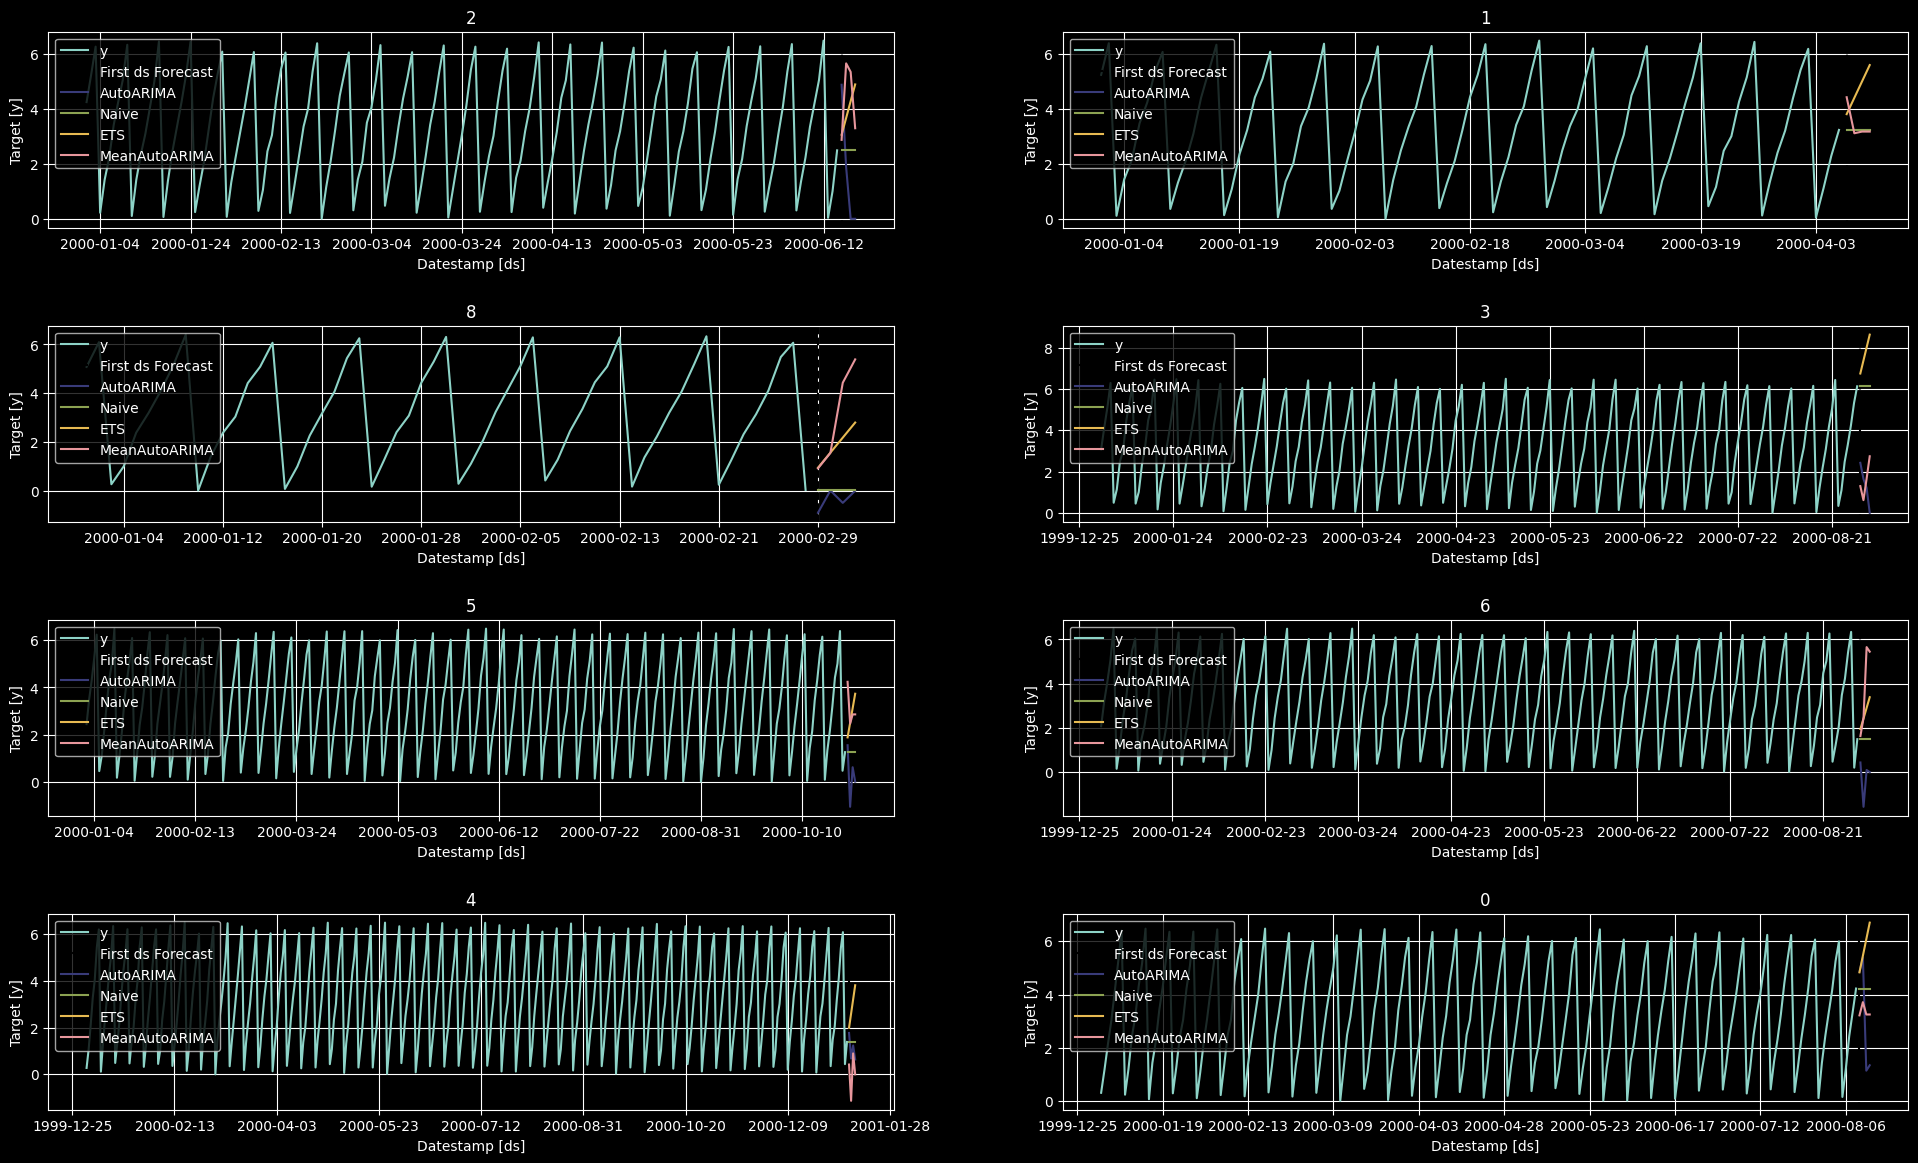

In [ ]:
#| hide
fcst.plot(panel_df, fcsts_df, engine='matplotlib')

In [ ]:
#| hide
# test plot with ds as object

panel_df['ds'] = panel_df['ds'].astype(str)
fcst.plot(panel_df, fcsts_df)

/var/folders/bf/sk4n3yp57sq6_v_80krxg0n80000gn/T/ipykernel_39652/2356550339.py:677: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.

/var/folders/bf/sk4n3yp57sq6_v_80krxg0n80000gn/T/ipykernel_39652/2356550339.py:677: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.

/var/folders/bf/sk4n3yp57sq6_v_80krxg0n80000gn/T/ipykernel_39652/2356550339.py:677: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.

/var/folders/bf/sk4n3yp57sq6_v_80krxg0n80000gn/T/ipykernel_39652/2356550339.py:677: Matplot

In [ ]:
#| hide
fcsts_df = fcst.forecast(h=4, fitted=True, level=[90, 80, 30])
fcsts_df.groupby('unique_id').tail(4)
fcst.plot(panel_df.groupby('unique_id').tail(28), fcsts_df, models=['AutoARIMA', 'ETS'], level=[90, 80])

Forecast: 100%|██████████| 9/9 [00:05<00:00,  1.61it/s]
/var/folders/bf/sk4n3yp57sq6_v_80krxg0n80000gn/T/ipykernel_39652/2356550339.py:677: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.

/var/folders/bf/sk4n3yp57sq6_v_80krxg0n80000gn/T/ipykernel_39652/2356550339.py:677: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.

/var/folders/bf/sk4n3yp57sq6_v_80krxg0n80000gn/T/ipykernel_39652/2356550339.py:677: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.

/var/folders/bf/sk4n3yp57sq6_v_80kr

In [ ]:
#| hide
fcst.plot(fcst.forecast_fitted_values(),
          forecasts_df=fcsts_df,
          models=['AutoARIMA', 'ETS'], level=[80], 
          max_insample_length=20,
          plot_anomalies=True)

/var/folders/bf/sk4n3yp57sq6_v_80krxg0n80000gn/T/ipykernel_39652/2356550339.py:677: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



In [ ]:
#| hide
fcst.plot(panel_df, fcsts_df, models=['AutoARIMA', 'Naive'])

/var/folders/bf/sk4n3yp57sq6_v_80krxg0n80000gn/T/ipykernel_39652/2356550339.py:677: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.

/var/folders/bf/sk4n3yp57sq6_v_80krxg0n80000gn/T/ipykernel_39652/2356550339.py:677: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.

/var/folders/bf/sk4n3yp57sq6_v_80krxg0n80000gn/T/ipykernel_39652/2356550339.py:677: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.

/var/folders/bf/sk4n3yp57sq6_v_80krxg0n80000gn/T/ipykernel_39652/2356550339.py:677: Matplot

In [ ]:
#| hide
fcst.plot(panel_df, fcsts_df, models=['AutoARIMA', 'Naive'], max_insample_length=28)

/var/folders/bf/sk4n3yp57sq6_v_80krxg0n80000gn/T/ipykernel_39652/2356550339.py:677: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.

/var/folders/bf/sk4n3yp57sq6_v_80krxg0n80000gn/T/ipykernel_39652/2356550339.py:677: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.

/var/folders/bf/sk4n3yp57sq6_v_80krxg0n80000gn/T/ipykernel_39652/2356550339.py:677: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.

/var/folders/bf/sk4n3yp57sq6_v_80krxg0n80000gn/T/ipykernel_39652/2356550339.py:677: Matplot

In [ ]:
#| hide
fcst.plot(panel_df.query('unique_id in [0, 1]'), fcsts_df, models=['AutoARIMA', 'Naive'], level=[90])

/var/folders/bf/sk4n3yp57sq6_v_80krxg0n80000gn/T/ipykernel_39652/2356550339.py:677: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.

/var/folders/bf/sk4n3yp57sq6_v_80krxg0n80000gn/T/ipykernel_39652/2356550339.py:677: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



In [ ]:
#| hide
fcst.plot(panel_df, unique_ids=[0, 1], models=['AutoARIMA', 'Naive'], level=[90])

/var/folders/bf/sk4n3yp57sq6_v_80krxg0n80000gn/T/ipykernel_39652/2356550339.py:677: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.

/var/folders/bf/sk4n3yp57sq6_v_80krxg0n80000gn/T/ipykernel_39652/2356550339.py:677: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



In [ ]:
#| hide
fcst.plot(panel_df.query('unique_id == 0'), fcsts_df, models=['AutoARIMA', 'Naive'], level=[90])

/var/folders/bf/sk4n3yp57sq6_v_80krxg0n80000gn/T/ipykernel_39652/2356550339.py:677: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



In [ ]:
#| hide
fcst.plot(panel_df, fcsts_df.query('unique_id == 0'), models=['AutoARIMA', 'Naive'], level=[90])

/var/folders/bf/sk4n3yp57sq6_v_80krxg0n80000gn/T/ipykernel_39652/2356550339.py:677: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



In [ ]:
#| hide
fcst.plot(panel_df, fcsts_df, unique_ids=[0], models=['AutoARIMA', 'Naive'], level=[90])

/var/folders/bf/sk4n3yp57sq6_v_80krxg0n80000gn/T/ipykernel_39652/2356550339.py:677: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



In [ ]:
#| hide
fcst.plot(panel_df.query('unique_id in [0, 1, 3]'), models=['AutoARIMA', 'Naive'], level=[90])

/var/folders/bf/sk4n3yp57sq6_v_80krxg0n80000gn/T/ipykernel_39652/2356550339.py:677: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.

/var/folders/bf/sk4n3yp57sq6_v_80krxg0n80000gn/T/ipykernel_39652/2356550339.py:677: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.

/var/folders/bf/sk4n3yp57sq6_v_80krxg0n80000gn/T/ipykernel_39652/2356550339.py:677: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



In [ ]:
#| hide
fcst.plot(panel_df, fcsts_df, unique_ids=[0, 1, 2], level=[90])

/var/folders/bf/sk4n3yp57sq6_v_80krxg0n80000gn/T/ipykernel_39652/2356550339.py:677: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.

/var/folders/bf/sk4n3yp57sq6_v_80krxg0n80000gn/T/ipykernel_39652/2356550339.py:677: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.

/var/folders/bf/sk4n3yp57sq6_v_80krxg0n80000gn/T/ipykernel_39652/2356550339.py:677: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



In [ ]:
#| hide
fig = fcst.plot(panel_df, fcsts_df, unique_ids=[0, 1, 2, 3, 4], models=['AutoARIMA', 'Naive'], level=[90])
fig.show()

/var/folders/bf/sk4n3yp57sq6_v_80krxg0n80000gn/T/ipykernel_39652/2356550339.py:677: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.

/var/folders/bf/sk4n3yp57sq6_v_80krxg0n80000gn/T/ipykernel_39652/2356550339.py:677: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.

/var/folders/bf/sk4n3yp57sq6_v_80krxg0n80000gn/T/ipykernel_39652/2356550339.py:677: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.

/var/folders/bf/sk4n3yp57sq6_v_80krxg0n80000gn/T/ipykernel_39652/2356550339.py:677: Matplot

/var/folders/bf/sk4n3yp57sq6_v_80krxg0n80000gn/T/ipykernel_39652/2356550339.py:792: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.

/var/folders/bf/sk4n3yp57sq6_v_80krxg0n80000gn/T/ipykernel_39652/2356550339.py:792: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.

/var/folders/bf/sk4n3yp57sq6_v_80krxg0n80000gn/T/ipykernel_39652/2356550339.py:792: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.

/var/folders/bf/sk4n3yp57sq6_v_80krxg0n80000gn/T/ipykernel_39652/2356550339.py:792: Matplot

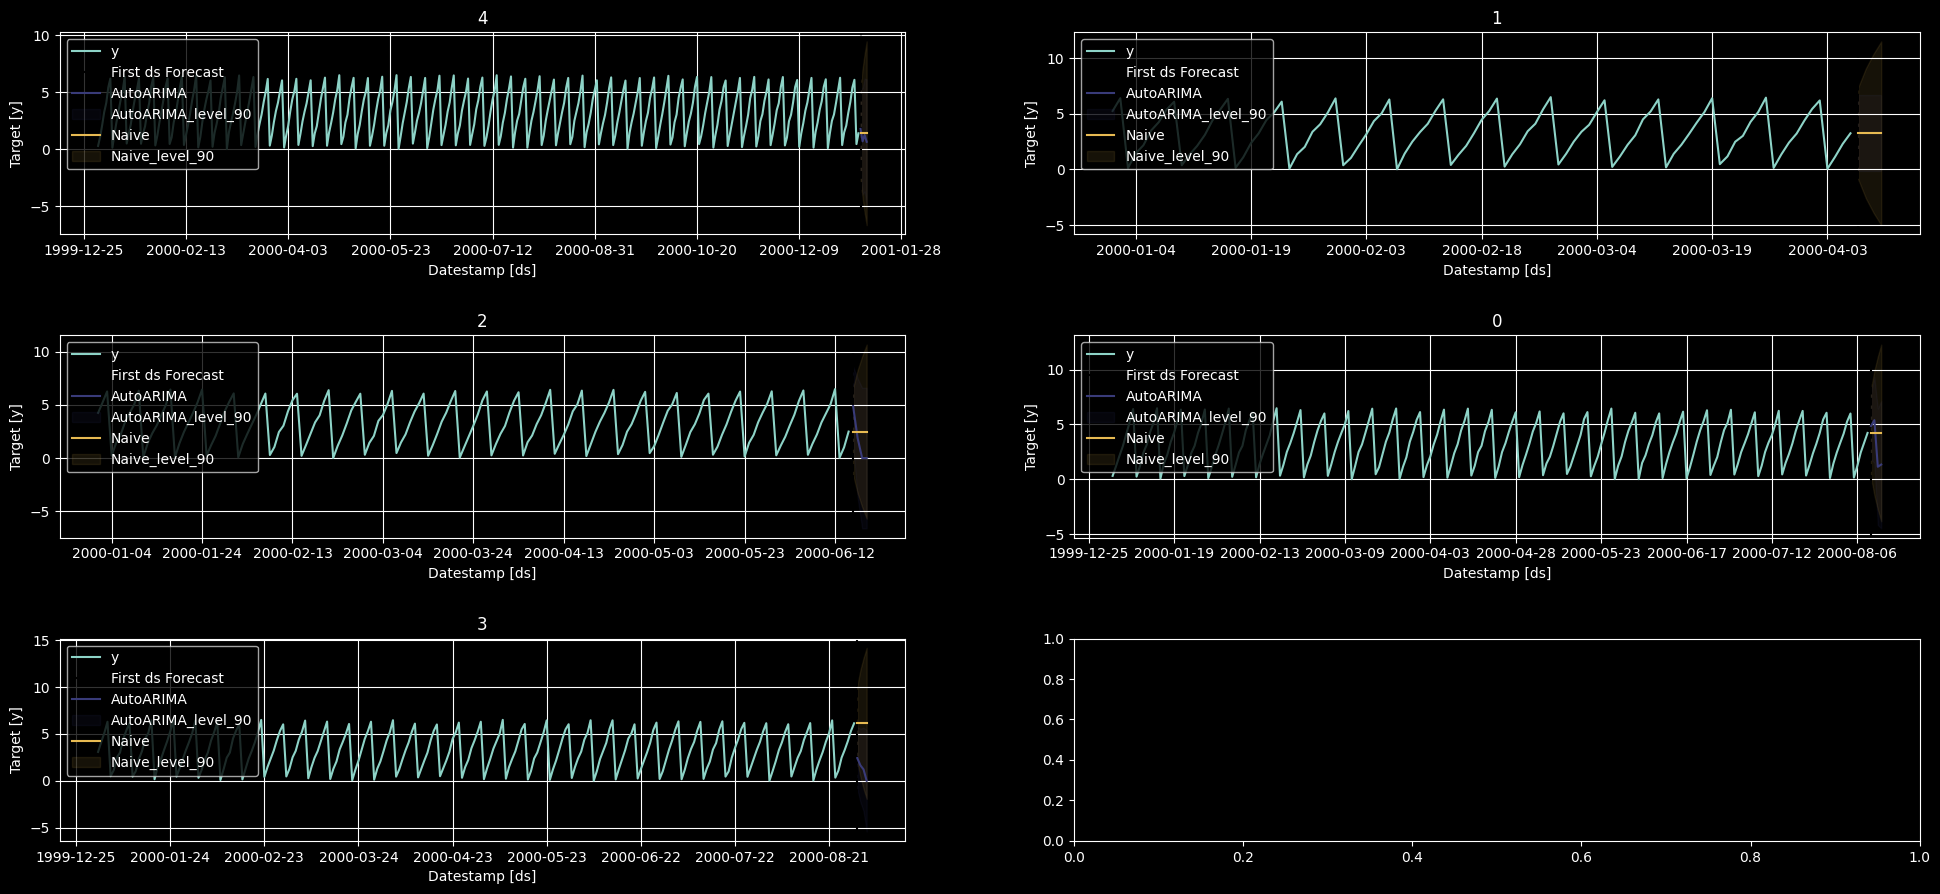

In [ ]:
#| hide
fig = fcst.plot(
    panel_df, fcsts_df, unique_ids=[0, 1, 2, 3, 4], 
    models=['AutoARIMA', 'Naive'], 
    level=[90],
    engine='matplotlib'
)
fig

In [ ]:
#| hide
fcst = StatsForecast(df=panel_df,
                     models=[AutoARIMA(season_length=7)],
                     freq='D', 
                     n_jobs=1, 
                     verbose=True)
fcsts_df = fcst.forecast(h=4, fitted=True, level=[90])
fcsts_df.groupby('unique_id').tail(4)
fitted_vals = fcst.forecast_fitted_values()
fcst.plot(panel_df, fitted_vals.drop(columns='y'), level=[90])

Forecast: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]
/var/folders/bf/sk4n3yp57sq6_v_80krxg0n80000gn/T/ipykernel_39652/2356550339.py:677: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.

/var/folders/bf/sk4n3yp57sq6_v_80krxg0n80000gn/T/ipykernel_39652/2356550339.py:677: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.

/var/folders/bf/sk4n3yp57sq6_v_80krxg0n80000gn/T/ipykernel_39652/2356550339.py:677: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.

/var/folders/bf/sk4n3yp57sq6_v_80kr

In [ ]:
show_doc(_StatsForecast.fit, 
         title_level=2,
         name='StatsForecast.fit')

---

[source](https://github.com/Nixtla/statsforecast/blob/main/statsforecast/core.py#L557){target="_blank" style="float:right; font-size:smaller"}

## StatsForecast.fit

>      StatsForecast.fit (df:Optional[pandas.core.frame.DataFrame]=None,
>                         sort_df:bool=True)

Fit statistical models.

Fit `models` to a large set of time series from DataFrame `df`
and store fitted models for later inspection.

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| df | Optional | None | DataFrame with columns [`unique_id`, `ds`, `y`] and exogenous.<br>If None, the `StatsForecast` class should have been instantiated<br>using `df`. |
| sort_df | bool | True | If True, sort `df` by [`unique_id`,`ds`]. |
| **Returns** | **StatsForecast** |  | **Returns with stored `StatsForecast` fitted `models`.** |

In [ ]:
show_doc(_StatsForecast.predict, 
         title_level=2,
         name='SatstForecast.predict')

---

[source](https://github.com/Nixtla/statsforecast/blob/main/statsforecast/core.py#L615){target="_blank" style="float:right; font-size:smaller"}

## SatstForecast.predict

>      SatstForecast.predict (h:int,
>                             X_df:Optional[pandas.core.frame.DataFrame]=None,
>                             level:Optional[List[int]]=None)

Predict statistical models.

Use stored fitted `models` to predict large set of time series from DataFrame `df`.

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| h | int |  | Forecast horizon. |
| X_df | Optional | None | DataFrame with [`unique_id`, `ds`] columns and `df`'s future exogenous. |
| level | Optional | None | Confidence levels between 0 and 100 for prediction intervals. |
| **Returns** | **pandas.DataFrame \| polars.DataFrame** |  | **DataFrame with `models` columns for point predictions and probabilistic<br>predictions for all fitted `models`.** |

In [ ]:
show_doc(_StatsForecast.fit_predict, 
         title_level=2,
         name='StatsForecast.fit_predict')

---

[source](https://github.com/Nixtla/statsforecast/blob/main/statsforecast/core.py#L649){target="_blank" style="float:right; font-size:smaller"}

## StatsForecast.fit_predict

>      StatsForecast.fit_predict (h:int,
>                                 df:Optional[pandas.core.frame.DataFrame]=None,
>                                 X_df:Optional[pandas.core.frame.DataFrame]=Non
>                                 e, level:Optional[List[int]]=None,
>                                 sort_df:bool=True)

Fit and Predict with statistical models.

This method avoids memory burden due from object storage.
It is analogous to Scikit-Learn `fit_predict` without storing information.
It requires the forecast horizon `h` in advance. 

In contrast to `StatsForecast.forecast` this method stores partial models outputs.

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| h | int |  | Forecast horizon. |
| df | Optional | None | DataFrame with columns [`unique_id`, `ds`, `y`] and exogenous variables.<br>If None, the `StatsForecast` class should have been instantiated<br>using `df`. |
| X_df | Optional | None | DataFrame with [`unique_id`, `ds`] columns and `df`'s future exogenous. |
| level | Optional | None | Confidence levels between 0 and 100 for prediction intervals. |
| sort_df | bool | True | If True, sort `df` by [`unique_id`,`ds`]. |
| **Returns** | **pandas.DataFrame \| polars.DataFrame** |  | **DataFrame with `models` columns for point predictions and probabilistic<br>predictions for all fitted `models`.** |

In [ ]:
show_doc(_StatsForecast.forecast, title_level=2, name='StatsForecast.forecast')

---

[source](https://github.com/Nixtla/statsforecast/blob/main/statsforecast/core.py#L700){target="_blank" style="float:right; font-size:smaller"}

## StatsForecast.forecast

>      StatsForecast.forecast (h:int,
>                              df:Optional[pandas.core.frame.DataFrame]=None,
>                              X_df:Optional[pandas.core.frame.DataFrame]=None,
>                              level:Optional[List[int]]=None,
>                              fitted:bool=False, sort_df:bool=True)

Memory Efficient predictions.

This method avoids memory burden due from object storage.
It is analogous to Scikit-Learn `fit_predict` without storing information.
It requires the forecast horizon `h` in advance.

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| h | int |  | Forecast horizon. |
| df | Optional | None | DataFrame with columns [`unique_id`, `ds`, `y`] and exogenous.<br>If None, the `StatsForecast` class should have been instantiated<br>using `df`. |
| X_df | Optional | None | DataFrame with [`unique_id`, `ds`] columns and `df`'s future exogenous. |
| level | Optional | None | Confidence levels between 0 and 100 for prediction intervals. |
| fitted | bool | False | Wether or not return insample predictions. |
| sort_df | bool | True | If True, sort `df` by [`unique_id`,`ds`]. |
| **Returns** | **pandas.DataFrame \| polars.DataFrame** |  | **DataFrame with `models` columns for point predictions and probabilistic<br>predictions for all fitted `models`.** |

In [ ]:
# StatsForecast.forecast method usage example

#from statsforecast.core import StatsForecast
from statsforecast.utils import AirPassengersDF as panel_df
from statsforecast.models import AutoARIMA, Naive

# Instantiate StatsForecast class
fcst = StatsForecast(df=panel_df,
                     models=[AutoARIMA(), Naive()],
                     freq='D', n_jobs=1)

# Efficiently predict without storing memory
fcsts_df = fcst.forecast(h=4, fitted=True)
fcsts_df.groupby('unique_id').tail(4)

,ds,AutoARIMA,Naive
unique_id,,,
1.0,1961-01-01,476.006500,432.0
1.0,1961-01-02,482.846222,432.0
1.0,1961-01-03,512.423523,432.0
1.0,1961-01-04,502.038269,432.0


In [ ]:
#| hide
series = generate_series(100, n_static_features=2, equal_ends=False)

models = [
    ADIDA(), CrostonClassic(), CrostonOptimized(),
    CrostonSBA(), HistoricAverage(), 
    IMAPA(), Naive(), 
    RandomWalkWithDrift(), 
    SeasonalExponentialSmoothing(season_length=7, alpha=0.1),
    SeasonalNaive(season_length=7),
    SeasonalWindowAverage(season_length=7, window_size=4),
    SimpleExponentialSmoothing(alpha=0.1),
    TSB(alpha_d=0.1, alpha_p=0.3),
    WindowAverage(window_size=4)
]

fcst = StatsForecast(
    df=series,
    models=models,
    freq='D',
    n_jobs=1,
    verbose=True
)

res = fcst.forecast(h=14)

fcst_no_idx = StatsForecast(
    df=series.reset_index(),
    models=models,
    freq='D',
)
test_eq(
    fcst_no_idx.forecast(h=14),
    res
)

Forecast: 100%|██████████| 100/100 [00:03<00:00, 26.43it/s]


In [ ]:
#| hide
# test series without ds as datetime
series_wo_dt = series.copy()
series_wo_dt['ds'] = series_wo_dt['ds'].astype(str) 
fcst = StatsForecast(df=series_wo_dt,
                     models=models,
                     freq='D')
fcsts_wo_dt = fcst.forecast(h=14)
test_eq(res, fcsts_wo_dt)

In [ ]:
#| hide
test_eq(res.index.unique(), fcst.uids)
last_dates = series.groupby('unique_id')['ds'].max()
test_eq(res.groupby('unique_id')['ds'].min().values, last_dates + pd.offsets.Day())
test_eq(res.groupby('unique_id')['ds'].max().values, last_dates + 14 * pd.offsets.Day())

In [ ]:
#| hide
#test for equal ends time series
series_eq_ends = generate_series(100, equal_ends=True)

fcst = StatsForecast(
    models=models,
    freq='D',
)
res = fcst.forecast(df=series_eq_ends, h=14)

test_eq(res.index.unique(), fcst.uids)
last_dates = series_eq_ends.groupby('unique_id')['ds'].max()
test_eq(res.groupby('unique_id')['ds'].min().values, last_dates + pd.offsets.Day())
test_eq(res.groupby('unique_id')['ds'].max().values, last_dates + 14 * pd.offsets.Day())

In [ ]:
#| hide
#tests for monthly data
monthly_series = generate_series(10_000, freq='M', min_length=10, max_length=20, equal_ends=True)
monthly_series

fcst = StatsForecast(
    models=[Naive()],
    freq='M'
)
monthly_res = fcst.forecast(df=monthly_series, h=4)
monthly_res

last_dates = monthly_series.groupby('unique_id')['ds'].max()
test_eq(monthly_res.groupby('unique_id')['ds'].min().values, fcst.last_dates + pd.offsets.MonthEnd())
test_eq(monthly_res.groupby('unique_id')['ds'].max().values, fcst.last_dates + 4 * pd.offsets.MonthEnd())

In [ ]:
show_doc(_StatsForecast.forecast_fitted_values, 
         title_level=2, 
         name='StatsForecast.forecast_fitted_values')

---

[source](https://github.com/Nixtla/statsforecast/blob/main/statsforecast/core.py#L760){target="_blank" style="float:right; font-size:smaller"}

## StatsForecast.forecast_fitted_values

>      StatsForecast.forecast_fitted_values ()

Access insample predictions.

After executing `StatsForecast.forecast`, you can access the insample 
prediction values for each model. To get them, you need to pass `fitted=True` 
to the `StatsForecast.forecast` method and then use the 
`StatsForecast.forecast_fitted_values` method.

In [ ]:
# StatsForecast.forecast_fitted_values method usage example

#from statsforecast.core import StatsForecast
from statsforecast.utils import AirPassengersDF as panel_df
from statsforecast.models import Naive

# Instantiate StatsForecast class
fcst = StatsForecast(df=panel_df,
                     models=[AutoARIMA()],
                     freq='D', n_jobs=1)

# Access insample predictions
fcsts_df = fcst.forecast(h=12, fitted=True, level=(90, 10))
insample_fcsts_df = fcst.forecast_fitted_values()
insample_fcsts_df.tail(4)

,ds,y,AutoARIMA,AutoARIMA-lo-90,AutoARIMA-lo-10,AutoARIMA-hi-10,AutoARIMA-hi-90
unique_id,,,,,,,
1.0,1960-09-30,508.0,572.654175,525.092163,569.020630,576.287781,620.216187
1.0,1960-10-31,461.0,451.528259,403.966248,447.894684,455.161835,499.090271
1.0,1960-11-30,390.0,437.915375,390.353363,434.281799,441.548981,485.477386
1.0,1960-12-31,432.0,369.718781,322.156769,366.085205,373.352356,417.280792


In [ ]:
#| hide
#tests for fitted values
def test_fcst_fitted(series, n_jobs=1, str_ds=False):
    if str_ds:
        series = series.copy()
        series['ds'] = series['ds'].astype(str)
    fitted_fcst = StatsForecast(
        df=series,
        models=[Naive()],
        freq='D',
        n_jobs=n_jobs,
    )
    fitted_res = fitted_fcst.forecast(14, fitted=True)
    fitted = fitted_fcst.forecast_fitted_values()
    if str_ds:
        test_eq(pd.to_datetime(series['ds']), fitted['ds'])
    else:
        test_eq(series['ds'], fitted['ds'])
    test_eq(series['y'].astype(np.float32), fitted['y'])
test_fcst_fitted(series)
test_fcst_fitted(series, str_ds=True)

In [ ]:
#| hide
#tests for fallback model
def test_fcst_fallback_model(n_jobs=1):
    fitted_fcst = StatsForecast(
        df=series,
        models=[NullModel()],
        freq='D',
        n_jobs=n_jobs,
        fallback_model=Naive()
    )
    fitted_res = fitted_fcst.forecast(14, fitted=True)
    fitted = fitted_fcst.forecast_fitted_values()
    test_eq(series['ds'], fitted['ds'])
    test_eq(series['y'].astype(np.float32), fitted['y'])
    # test NullModel actualy fails
    fitted_fcst = StatsForecast(
        df=series,
        models=[NullModel()],
        freq='D',
        n_jobs=n_jobs,
    )
    test_fail(fitted_fcst.forecast, kwargs={'h': 14})
test_fcst_fallback_model()

In [ ]:
show_doc(_StatsForecast.cross_validation, 
         title_level=2, 
         name='StatsForecast.cross_validation')

---

[source](https://github.com/Nixtla/statsforecast/blob/main/statsforecast/core.py#L786){target="_blank" style="float:right; font-size:smaller"}

## StatsForecast.cross_validation

>      StatsForecast.cross_validation (h:int,
>                                      df:Optional[pandas.core.frame.DataFrame]=
>                                      None, n_windows:int=1, step_size:int=1,
>                                      test_size:Optional[int]=None,
>                                      input_size:Optional[int]=None,
>                                      level:Optional[List[int]]=None,
>                                      fitted:bool=False, refit:bool=True,
>                                      sort_df:bool=True)

Temporal Cross-Validation.

Efficiently fits a list of `StatsForecast` 
models through multiple training windows, in either chained or rolled manner.

`StatsForecast.models`' speed allows to overcome this evaluation technique 
high computational costs. Temporal cross-validation provides better model's 
generalization measurements by increasing the test's length and diversity.

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| h | int |  | Forecast horizon. |
| df | Optional | None | DataFrame with columns [`unique_id`, `ds`, `y`] and exogenous.<br>If None, the `StatsForecast` class should have been instantiated<br>using `df`. |
| n_windows | int | 1 | Number of windows used for cross validation. |
| step_size | int | 1 | Step size between each window. |
| test_size | Optional | None | Length of test size. If passed, set `n_windows=None`. |
| input_size | Optional | None | Input size for each window, if not none rolled windows. |
| level | Optional | None | Confidence levels between 0 and 100 for prediction intervals. |
| fitted | bool | False | Wether or not returns insample predictions. |
| refit | bool | True | Wether or not refit the model for each window. |
| sort_df | bool | True | If True, sort `df` by `unique_id` and `ds`. |
| **Returns** | **pandas.DataFrame \| polars.DataFrame** |  | **DataFrame with insample `models` columns for point predictions and probabilistic<br>predictions for all fitted `models`.** |

In [ ]:
# StatsForecast.crossvalidation method usage example

#from statsforecast.core import StatsForecast
from statsforecast.utils import AirPassengersDF as panel_df
from statsforecast.models import Naive

# Instantiate StatsForecast class
fcst = StatsForecast(df=panel_df,
                     models=[Naive()],
                     freq='D', n_jobs=1, verbose=True)

# Access insample predictions
rolled_fcsts_df = fcst.cross_validation(14, n_windows=2)
rolled_fcsts_df.head(4)

Cross Validation Time Series 1: 100%|██████████| 2/2 [00:00<00:00, 12965.39it/s]


,ds,cutoff,y,Naive
unique_id,,,,
1.0,1960-12-17,1960-12-16,407.0,463.0
1.0,1960-12-18,1960-12-16,362.0,463.0
1.0,1960-12-19,1960-12-16,405.0,463.0
1.0,1960-12-20,1960-12-16,417.0,463.0


In [ ]:
#| hide
#test for cross_validation
series_cv = pd.DataFrame({
    'ds': np.hstack([
        pd.date_range(end='2021-01-01', freq='D', periods=10),
        pd.date_range(end='2022-01-01', freq='D', periods=100),
        pd.date_range(end='2020-01-01', freq='D', periods=20)
    ]),
    'y': np.hstack([np.arange(10.), np.arange(100, 200), np.arange(20, 40)])
}, index=pd.Index(
    data=np.hstack([np.zeros(10), np.zeros(100) + 1, np.zeros(20) + 2]),
    name='unique_id'
))

fcst = StatsForecast(
    df=series_cv,
    models=[SumAhead(), Naive()],
    freq='D',
    verbose=True
)
res_cv = fcst.cross_validation(h=2, test_size=5, n_windows=None, level=(50, 60))
test_eq(0., np.mean(res_cv['y'] - res_cv['SumAhead']))

n_windows = fcst.cross_validation(h=2, n_windows=2).groupby('unique_id').size().unique()
test_eq(n_windows, 2 * 2)
test_eq(0., np.mean(res_cv['y'] - res_cv['SumAhead']))

n_windows = fcst.cross_validation(h=3, n_windows=3, step_size=3, fitted=True).groupby('unique_id').size().unique()
test_eq(n_windows, 3 * 3)
test_eq(0., np.mean(res_cv['y'] - res_cv['SumAhead']))

Cross Validation Time Series 3: 100%|██████████| 3/3 [00:00<00:00, 17331.83it/s]


In [ ]:
#| hide
# test cross validation refit=False
fcst = StatsForecast(
    df=series_cv,
    models=[SumAhead()],
    freq='D',
    verbose=True
)
res_cv_wo_refit = fcst.cross_validation(h=2, test_size=5, n_windows=None, level=(50, 60), refit=False)
test_fail(test_eq, args=(res_cv_wo_refit, res_cv))
cols_wo_refit = res_cv_wo_refit.columns
test_eq(res_cv_wo_refit.groupby('unique_id').head(1), 
        res_cv[cols_wo_refit].groupby('unique_id').head(1))

n_windows = fcst.cross_validation(h=2, n_windows=2, refit=False).groupby('unique_id').size().unique()
test_eq(n_windows, 2 * 2)

n_windows = fcst.cross_validation(h=3, n_windows=3, step_size=3, fitted=True, refit=False).groupby('unique_id').size().unique()
test_eq(n_windows, 3 * 3)

Cross Validation Time Series 3: 100%|██████████| 3/3 [00:00<00:00, 27001.96it/s]


In [ ]:
#| hide
# test cross validation refit=False
fcst = StatsForecast(
    df=series_cv,
    models=[DynamicOptimizedTheta(), AutoCES(), 
            DynamicOptimizedTheta(season_length=7, alias='test')],
    freq='D',
    verbose=True
)
res_cv_wo_refit = fcst.cross_validation(h=2, test_size=5, n_windows=None, level=(50, 60), refit=False)
res_cv_w_refit = fcst.cross_validation(h=2, test_size=5, n_windows=None, level=(50, 60), refit=True)
test_fail(test_eq, args=(res_cv_wo_refit, res_cv_w_refit))
test_eq(
    res_cv_wo_refit.groupby('unique_id').head(1), 
    res_cv_w_refit.groupby('unique_id').head(1)
)

Cross Validation Time Series 3: 100%|██████████| 4/4 [00:00<00:00, 31.40it/s]


In [ ]:
#| hide
# test series without ds as datetime
series_cv_wo_dt = series_cv.copy()
series_cv_wo_dt['ds'] = series_cv_wo_dt['ds'].astype(str) 
fcst = StatsForecast(
    df=series_cv_wo_dt,
    models=[SumAhead(), Naive()],
    freq='D',
    verbose=False
)
res_cv_wo_dt = fcst.cross_validation(h=2, test_size=5, n_windows=None, level=(50, 60))
test_eq(res_cv, res_cv_wo_dt)

In [ ]:
#| hide
#test for equal ends cross_validation
series_cv = pd.DataFrame({
    'ds': np.hstack([
        pd.date_range(end='2022-01-01', freq='D', periods=10),
        pd.date_range(end='2022-01-01', freq='D', periods=100),
        pd.date_range(end='2022-01-01', freq='D', periods=20)
    ]),
    'y': np.hstack([np.arange(10), np.arange(100, 200), np.arange(20, 40)])
}, index=pd.Index(
    data=np.hstack([np.zeros(10), np.zeros(100) + 1, np.zeros(20) + 2]),
    name='unique_id'
))
fcst = StatsForecast(
    models=[SumAhead()],
    freq='D',
)
res_cv = fcst.cross_validation(df=series_cv, h=2, test_size=5, n_windows=None, level=(50,60), fitted=True)
test_eq(0., np.mean(res_cv['y'] - res_cv['SumAhead']))

n_windows = fcst.cross_validation(h=2, n_windows=2).groupby('unique_id').size().unique()
test_eq(n_windows, 2 * 2)
test_eq(0., np.mean(res_cv['y'] - res_cv['SumAhead']))

n_windows = fcst.cross_validation(h=3, n_windows=3, step_size=3).groupby('unique_id').size().unique()
test_eq(n_windows, 3 * 3)
test_eq(0., np.mean(res_cv['y'] - res_cv['SumAhead']))

In [ ]:
show_doc(_StatsForecast.cross_validation_fitted_values, 
         title_level=2, 
         name='StatsForecast.cross_validation_fitted_values')

---

[source](https://github.com/Nixtla/statsforecast/blob/main/statsforecast/core.py#L893){target="_blank" style="float:right; font-size:smaller"}

## StatsForecast.cross_validation_fitted_values

>      StatsForecast.cross_validation_fitted_values ()

Access insample cross validated predictions.

After executing `StatsForecast.cross_validation`, you can access the insample 
prediction values for each model and window. To get them, you need to pass `fitted=True` 
to the `StatsForecast.cross_validation` method and then use the 
`StatsForecast.cross_validation_fitted_values` method.

In [ ]:
# StatsForecast.cross_validation_fitted_values method usage example

#from statsforecast.core import StatsForecast
from statsforecast.utils import AirPassengersDF as panel_df
from statsforecast.models import Naive

# Instantiate StatsForecast class
fcst = StatsForecast(df=panel_df,
                     models=[Naive()],
                     freq='D', n_jobs=1)

# Access insample predictions
rolled_fcsts_df = fcst.cross_validation(h=12, n_windows=2, fitted=True)
insample_rolled_fcsts_df = fcst.cross_validation_fitted_values()
insample_rolled_fcsts_df.tail(4)

,ds,cutoff,y,Naive
unique_id,,,,
1.0,1959-09-30,1959-12-31,463.0,559.0
1.0,1959-10-31,1959-12-31,407.0,463.0
1.0,1959-11-30,1959-12-31,362.0,407.0
1.0,1959-12-31,1959-12-31,405.0,362.0


In [ ]:
#| hide
#tests for fitted values cross_validation
def test_cv_fitted(series_cv, n_jobs=1, str_ds=False):
    if str_ds:
        series_cv = series_cv.copy()
        series_cv['ds'] = series_cv['ds'].astype(str)
    resids_fcst = StatsForecast(
        df=series_cv,
        models=[SumAhead(), Naive()],
        freq='D',
        n_jobs=n_jobs
    )
    resids_res_cv = resids_fcst.cross_validation(h=2, n_windows=4, fitted=True)
    resids_cv = resids_fcst.cross_validation_fitted_values()
    np.testing.assert_array_equal(
        resids_cv['cutoff'].unique(),
        resids_res_cv['cutoff'].unique()
    )
    if str_ds:
        series_cv['ds'] = pd.to_datetime(series_cv['ds'])
    for uid in resids_cv.index.unique():
        for cutoff in resids_cv.loc[uid]['cutoff'].unique():
            pd.testing.assert_frame_equal(
                resids_cv.loc[uid].query('cutoff == @cutoff')[['ds', 'y']], 
                series_cv.query('ds <= @cutoff & unique_id == @uid')[['ds', 'y']],
                check_dtype=False
            )
test_cv_fitted(series_cv)
test_cv_fitted(series_cv, str_ds=True)

In [ ]:
#| hide
#tests for fallback model
def test_cv_fallback_model(n_jobs=1):
    fitted_fcst = StatsForecast(
        df=series,
        models=[NullModel()],
        freq='D',
        n_jobs=n_jobs,
        fallback_model=Naive()
    )
    fitted_res = fitted_fcst.cross_validation(h=2, n_windows=4, fitted=True)
    fitted = fitted_fcst.cross_validation_fitted_values()
    # test NullModel actualy fails
    fitted_fcst = StatsForecast(
        df=series,
        models=[NullModel()],
        freq='D',
        n_jobs=n_jobs,
    )
    test_fail(fitted_fcst.cross_validation, 
              kwargs={'h': 2, 'n_windows': 4}, 
              contains='got an unexpected keyword argument')
test_cv_fallback_model()

In [ ]:
show_doc(_StatsForecast.plot, 
         title_level=2, 
         name='StatsForecast.plot')

---

[source](https://github.com/Nixtla/statsforecast/blob/main/statsforecast/core.py#L1082){target="_blank" style="float:right; font-size:smaller"}

## StatsForecast.plot

>      StatsForecast.plot
>                          (df:Union[pandas.core.frame.DataFrame,polars.datafram
>                          e.frame.DataFrame], forecasts_df:Optional[pandas.core
>                          .frame.DataFrame]=None, unique_ids:Union[List[str],No
>                          neType,numpy.ndarray]=None, plot_random:bool=True,
>                          models:Optional[List[str]]=None,
>                          level:Optional[List[float]]=None,
>                          max_insample_length:Optional[int]=None,
>                          plot_anomalies:bool=False, engine:str='plotly',
>                          resampler_kwargs:Optional[Dict]=None)

Plot forecasts and insample values.

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| df | Union |  | DataFrame with columns [`unique_id`, `ds`, `y`]. |
| forecasts_df | Optional | None | DataFrame with columns [`unique_id`, `ds`] and models. |
| unique_ids | Union | None | Time Series to plot.<br>If None, time series are selected randomly. |
| plot_random | bool | True | Select time series to plot randomly. |
| models | Optional | None | List of models to plot. |
| level | Optional | None | List of prediction intervals to plot if paseed. |
| max_insample_length | Optional | None | Max number of train/insample observations to be plotted. |
| plot_anomalies | bool | False | Plot anomalies for each prediction interval. |
| engine | str | plotly | Library used to plot. 'plotly', 'plotly-resampler' or 'matplotlib'. |
| resampler_kwargs | Optional | None | Kwargs to be passed to plotly-resampler constructor. <br>For further custumization ("show_dash") call the method,<br>store the plotting object and add the extra arguments to<br>its `show_dash` method. |

In [ ]:
#| hide
fcst = fcst.fit(df=series)

In [ ]:
#| hide
test_eq(
    fcst.predict(h=12),
    fcst.forecast(h=12)
)

In [ ]:
#| hide
test_eq(
    fcst.fit_predict(h=12),
    fcst.forecast(h=12)
)

In [ ]:
#| hide
#| eval: false
#tests for parallel processing
fcst = StatsForecast(
    df=series,
    models=[ADIDA(), SimpleExponentialSmoothing(0.1), 
            HistoricAverage(), CrostonClassic()],
    freq='D',
    n_jobs=-1
)
res = fcst.forecast(14)
res_cv = fcst.cross_validation(h=3, test_size=10, n_windows=None)
fcst = StatsForecast(
    df=series_cv,
    models=[SumAhead()],
    freq='D',
)
res_cv = fcst.cross_validation(h=2, test_size=5, n_windows=None)
test_eq(0., np.mean(res_cv['y'] - res_cv['SumAhead']))

test_fcst_fitted(series, n_jobs=-1)
test_cv_fitted(series_cv, n_jobs=-1)
test_fcst_fitted(series, n_jobs=-1, str_ds=True)
test_cv_fitted(series_cv, n_jobs=-1, str_ds=True)
# check n_windows argument
n_windows = fcst.cross_validation(h=2, n_windows=2).groupby('unique_id').size().unique()
test_eq(n_windows, 2 * 2)
test_eq(0., np.mean(res_cv['y'] - res_cv['SumAhead']))
# check step_size argument
n_windows = fcst.cross_validation(h=3, n_windows=3, step_size=3).groupby('unique_id').size().unique()
test_eq(n_windows, 3 * 3)
test_eq(0., np.mean(res_cv['y'] - res_cv['SumAhead']))

# Misc

## Integer datestamp

The `StatsForecast` class can also receive integers as datestamp, the following example shows how to do it.

In [ ]:
from statsforecast.core import StatsForecast
from statsforecast.utils import AirPassengers as ap
from statsforecast.models import HistoricAverage

In [ ]:
int_ds_df = pd.DataFrame({'ds': np.arange(1, len(ap) + 1), 'y': ap})
int_ds_df.insert(0, 'unique_id', 'AirPassengers')
int_ds_df.set_index('unique_id', inplace=True)
int_ds_df.head()

,ds,y
unique_id,,
AirPassengers,1,112.0
AirPassengers,2,118.0
AirPassengers,3,132.0
AirPassengers,4,129.0
AirPassengers,5,121.0


In [ ]:
int_ds_df.tail()

,ds,y
unique_id,,
AirPassengers,140,606.0
AirPassengers,141,508.0
AirPassengers,142,461.0
AirPassengers,143,390.0
AirPassengers,144,432.0


In [ ]:
fcst = StatsForecast(df=int_ds_df, models=[HistoricAverage()], freq='D')
horizon = 7
forecast = fcst.forecast(horizon)
forecast.head()

,ds,HistoricAverage
unique_id,,
AirPassengers,145,280.298615
AirPassengers,146,280.298615
AirPassengers,147,280.298615
AirPassengers,148,280.298615
AirPassengers,149,280.298615


In [ ]:
last_date = int_ds_df['ds'].max()
test_eq(forecast['ds'].values, np.arange(last_date + 1, last_date + 1 + horizon))

In [ ]:
int_ds_cv = fcst.cross_validation(h=7, test_size=8, n_windows=None)
int_ds_cv

,ds,cutoff,y,HistoricAverage
unique_id,,,,
AirPassengers,137,136,472.0,267.183838
AirPassengers,138,136,535.0,267.183838
AirPassengers,139,136,622.0,267.183838
AirPassengers,140,136,606.0,267.183838
AirPassengers,141,136,508.0,267.183838
AirPassengers,142,136,461.0,267.183838
AirPassengers,143,136,390.0,267.183838
AirPassengers,138,137,535.0,268.678833
AirPassengers,139,137,622.0,268.678833


## External regressors

Every column after **y** is considered an external regressor and will be passed to the models that allow them. If you use them you must supply the future values to the `StatsForecast.forecast` method.

In [ ]:
class LinearRegression:
    
    def __init__(self):
        pass
    
    def fit(self, y, X):
        self.coefs_, *_ = np.linalg.lstsq(X, y, rcond=None)
        return self
    
    def predict(self, h, X):
        mean = X @ coefs
        return mean
    
    def __repr__(self):
        return 'LinearRegression()'
    
    def forecast(self, y, h, X=None, X_future=None, fitted=False):
        coefs, *_ = np.linalg.lstsq(X, y, rcond=None)
        return {'mean': X_future @ coefs}
    
    def new(self):
        b = type(self).__new__(type(self))
        b.__dict__.update(self.__dict__)
        return b

In [ ]:
series_xreg = series = generate_series(10_000, equal_ends=True)
series_xreg['intercept'] = 1
series_xreg['dayofweek'] = series_xreg['ds'].dt.dayofweek
series_xreg = pd.get_dummies(series_xreg, columns=['dayofweek'], drop_first=True)
series_xreg

,ds,y,intercept,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6
unique_id,,,,,,,,,
0,2000-10-05,0.123838,1,0,0,1,0,0,0
0,2000-10-06,1.460113,1,0,0,0,1,0,0
0,2000-10-07,2.418577,1,0,0,0,0,1,0
0,2000-10-08,3.372232,1,0,0,0,0,0,1
0,2000-10-09,4.241948,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
9999,2001-05-10,2.338823,1,0,0,1,0,0,0
9999,2001-05-11,3.402687,1,0,0,0,1,0,0
9999,2001-05-12,4.235569,1,0,0,0,0,1,0


In [ ]:
dates = sorted(series_xreg['ds'].unique())
valid_start = dates[-14]
train_mask = series_xreg['ds'] < valid_start
series_train = series_xreg[train_mask]
series_valid = series_xreg[~train_mask]
X_valid = series_valid.drop(columns=['y'])
fcst = StatsForecast(
    df=series_train,
    models=[LinearRegression()],
    freq='D',
)
xreg_res = fcst.forecast(14, X_df=X_valid)
xreg_res['y'] = series_valid['y'].values

<Axes: xlabel='ds'>

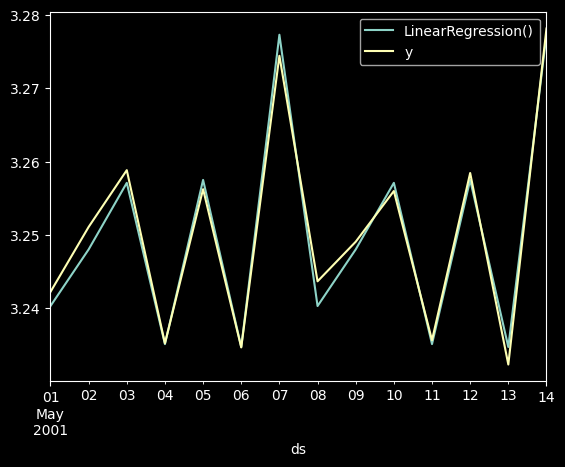

In [ ]:
xreg_res.groupby('ds').mean().plot()

In [ ]:
xreg_res_cv = fcst.cross_validation(h=3, test_size=5, n_windows=None)

In [ ]:
#| hide
# the following cells contain tests for external regressors

In [ ]:
#| hide
class ReturnX:
    
    def __init__(self):
        pass
    
    def fit(self, y, X):
        return self
    
    def predict(self, h, X):
        mean = X
        return X
    
    def __repr__(self):
        return 'ReturnX'
    
    def forecast(self, y, h, X=None, X_future=None, fitted=False):
        return {'mean': X_future.flatten()}
    
    def new(self):
        b = type(self).__new__(type(self))
        b.__dict__.update(self.__dict__)
        return b

In [ ]:
#| hide
df = pd.DataFrame(
    {
        'ds': np.hstack([np.arange(10), np.arange(10)]),
        'y': np.random.rand(20),
        'x': np.arange(20, dtype=np.float32),
    },
    index=pd.Index([0] * 10 + [1] * 10, name='unique_id'),
)
train_mask = df['ds'] < 6
train_df = df[train_mask]
test_df = df[~train_mask]

In [ ]:
#| hide
def test_x_vars(n_jobs=1):
    fcst = StatsForecast(
        df=train_df,
        models=[ReturnX()],
        freq='M',
        n_jobs=n_jobs,
    )
    xreg = test_df.drop(columns='y')
    res = fcst.forecast(4, X_df=xreg)
    expected_res = xreg.rename(columns={'x': 'ReturnX'})
    pd.testing.assert_frame_equal(res, expected_res, check_dtype=False)
test_x_vars(n_jobs=1)

In [ ]:
#| hide
#| eval: false
test_x_vars(n_jobs=2)

## Confidence intervals

You can pass the argument `level` to the `StatsForecast.forecast` method to calculate confidence intervals. Not all models can calculate them at the moment, so we will only obtain the intervals of those models that have it implemented. 

<Axes: xlabel='ds'>

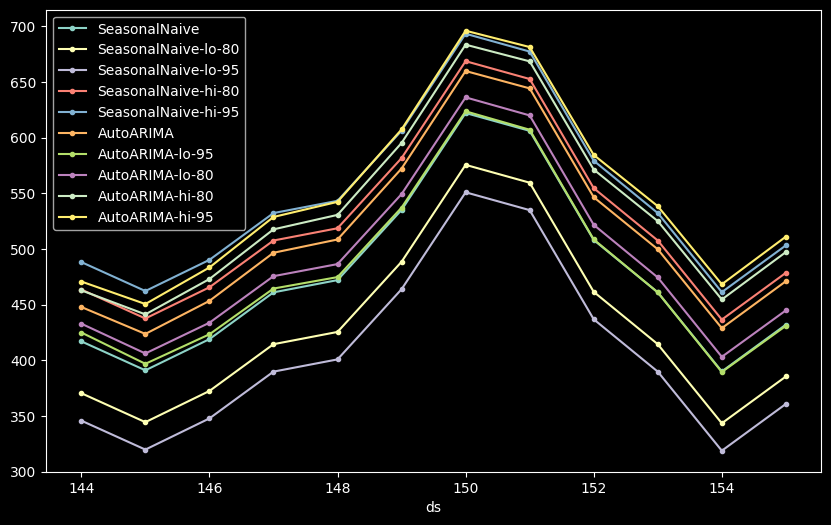

In [ ]:
ap_df = pd.DataFrame({'ds': np.arange(ap.size), 'y': ap}, index=pd.Index([0] * ap.size, name='unique_id'))
fcst = StatsForecast(
    df=ap_df,
    models=[
        SeasonalNaive(season_length=12), 
        AutoARIMA(season_length=12)
    ],
    freq='M',
    n_jobs=1
)
ap_ci = fcst.forecast(12, level=(80, 95))
ap_ci.set_index('ds').plot(marker='.', figsize=(10, 6))

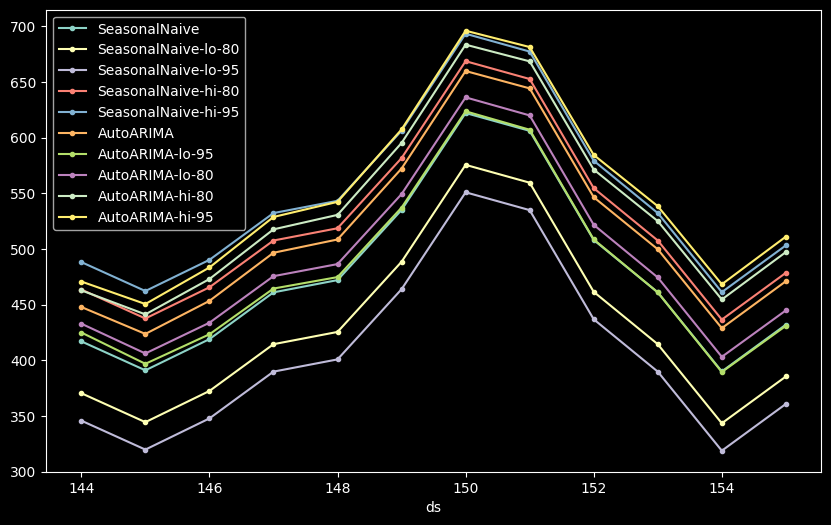

In [ ]:
#hide
def test_conf_intervals(n_jobs=1):
    ap_df = pd.DataFrame({'ds': np.arange(ap.size), 'y': ap}, index=pd.Index([0] * ap.size, name='unique_id'))
    fcst = StatsForecast(
        df=ap_df,
        models=[
            SeasonalNaive(season_length=12), 
            AutoARIMA(season_length=12)
        ],
        freq='M',
        n_jobs=n_jobs
    )
    ap_ci = fcst.forecast(12, level=(80, 95))
    ap_ci.set_index('ds').plot(marker='.', figsize=(10, 6))
test_conf_intervals(n_jobs=1)

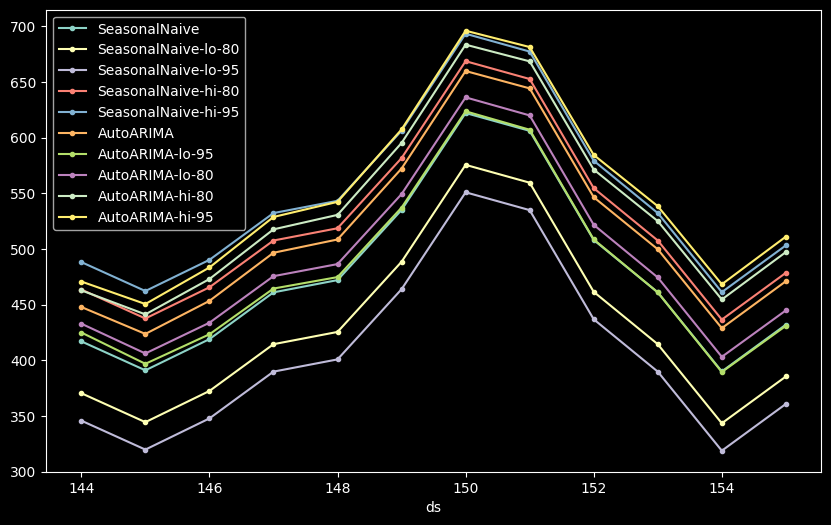

In [ ]:
#| hide
#| eval: false
#test number of jobs greater than the available cores
test_conf_intervals(n_jobs=101)